## Packages 

In [2]:
import helper
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib import pyplot
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
from tqdm import tqdm_notebook as tqdm

## Modules 

In [3]:
#Sets the backend of matplotlib to the 'inline' backend. With this backend, the output of plotting commands is displayed 
#...inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots 
#...will then also be stored in the notebook document.
%matplotlib inline

In [4]:
def snr(noisy_signals, signals):
    #signal to noise ratio
    return np.mean(np.square(signals), axis = 1) / np.mean(np.square(signals - noisy_signals), axis = 1)

In [5]:
def mean_snr(noisy_signals, signals):
    return np.mean(snr(noisy_signals, signals))

In [6]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [7]:
wholebatchtrainloader = torch.utils.data.DataLoader(trainset, batch_size=60000, shuffle=True)

In [8]:
minibatchtrainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [9]:
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, transform=transform, train=False)

In [10]:
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=True)

In [11]:
def calculate_accuracy(output, label):
    correct_count = 0
    all_count = 0
    #calculates accuracy of output (numpy array) with respect to label (numpy array)
    for i in range(len(label)):
        output_list = list(output[i])
        pred_label = output_list.index(max(output_list))
        true_label = label[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1
    accuracy = correct_count/all_count
    return accuracy

In [12]:
def plot_against_epochs(values, epochs, label="", title="", ax=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(12, 4))
        
    xs = np.linspace(0, epochs, num=len(values))

    ax.plot(xs, values);
    ax.set_ylabel(label); ax.set_xlabel("epochs");
    ax.set_title(title)

def plot_loss_and_accuracy(losses, accuracies, epochs, title="", axs=None):
    if axs is None:
        f, axs = plt.subplots(figsize=(12, 8), sharex=True, nrows=2)

    plot_against_epochs(losses, epochs, "loss", title, axs[0])

    plot_against_epochs(accuracies, epochs, "accuracy", ax=axs[1])

def plot_snr_and_accuracy(snrs, accuracies, epochs, title="", axs=None):
    if axs is None:
        f, axs = plt.subplots(figsize=(12, 8), sharex=True, nrows=2)

    plot_against_epochs(snrs, epochs, "signal-to-noise ratio", title, axs[0])

    plot_against_epochs(accuracies, epochs, "accuracy", ax=axs[1])

In [13]:
#generic teacher network training (using labels) module
def train_teacher(trainloader, optimizer_constructor, teacher,
                  teacher_criterion=nn.NLLLoss(), epochs=2):
    accuracies = []
    losses = []
    
    optimizer = optimizer_constructor(teacher.parameters(), lr=0.03)
    
    for e in range(epochs):
        print(f"EPOCH: {e}")
        running_loss = 0
        for images, labels in tqdm(trainloader):
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            # Clear the gradients, do this because gradients are accumulated
            optimizer.zero_grad()

            # Forward pass, get our log-probabilities
            teacher_output = teacher(images)

            # Calculate the loss with the logps and the labels
            teacher_loss = teacher_criterion(teacher_output, labels)

            teacher_probabilities = torch.exp(teacher_output)
            teacher_probabilities_np = teacher_probabilities.detach().numpy()
            labels_np = labels.detach().numpy()
            teacher_accuracy = calculate_accuracy(teacher_probabilities_np, labels_np)

            accuracies.append(teacher_accuracy)
            losses.append(teacher_loss)
            # Perform backward pass (i.e., backpropagation) to update the weights with gradient descent
            teacher_loss.backward()

            # Take an update step and few the new weights
            optimizer.step()

            running_loss += teacher_loss.item()
        else:
            print(f"Training loss: {running_loss / len(trainloader)}")
            
    return accuracies, losses

In [14]:
# Build a feed-forward network for the teacher.
teacher = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Build a feed-forward network for the big teacher.
big_teacher = nn.Sequential(nn.Linear(784, 1280),
                      nn.ReLU(),
                      nn.Linear(1280, 640),
                      nn.ReLU(),
                      nn.Linear(640, 10),
                      nn.LogSoftmax(dim=1))

epochs = 2

In [15]:
#generic student network training (using generic teacher network's output) module

def train_student_against_teacher(trainloader, optimizer_constructor, teacher, student, student_criterion=nn.MSELoss(), epochs=1):
    headless_teacher = nn.Sequential(*list(teacher.children())[:-1])
    headless_student = nn.Sequential(*list(student.children())[:-1])
    
    accuracies_wrt_labels = []
    accuracies_wrt_teacher = []
    losses = []
    snrs = []
    
    optimizer = optimizer_constructor(student.parameters(), lr=0.03)
    
    for e in range(epochs):
        print(f"EPOCH: {e}")
        running_loss = 0
        for images, labels in tqdm(trainloader):
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            # Clear the gradients, do this because gradients are accumulated
            optimizer.zero_grad()

            # Forward pass of headless networks
            student_logits = headless_student(images)
            teacher_logits = headless_teacher(images)

            # student loss is between student and teacher logits
            student_loss = student_criterion(student_logits, teacher_logits)
        
            student_logits_np = student_logits.detach().numpy()
            labels_np = labels.detach().numpy()
            student_accuracy_wrt_labels = calculate_accuracy(student_logits_np, labels_np)
            accuracies_wrt_labels.append(student_accuracy_wrt_labels)
            teacher_logits_np = teacher_logits.detach().numpy()
            
            teacher_logits_np_list = []
            for i in range(len(list(teacher_logits_np))):
                teacher_list = list(teacher_logits_np[i])
                teacher_logits_np_list.append(max(teacher_list))
            
            student_accuracy_wrt_teacher = calculate_accuracy(student_logits_np, teacher_logits_np_list)
            accuracies_wrt_teacher.append(student_accuracy_wrt_teacher)
        
            losses.append(student_loss)
        
            # Perform backward pass (i.e., backpropagation) to update the weights with gradient descent
            student_loss.backward()
        
            # Take an update step and few the new weights
            optimizer.step()
        
            running_loss += student_loss.item()
        
            #student_logits_np = student_logits.detach().numpy()
            #teacher_logits_np = teacher_logits.detach().numpy()
            batch_mean_signal_to_noise_ratio = mean_snr(student_logits_np, teacher_logits_np)
            snrs.append(batch_mean_signal_to_noise_ratio)        
        
        else:
            print(f"Training loss: {running_loss / len(trainloader)}")
            
    return accuracies_wrt_labels, accuracies_wrt_teacher, losses, snrs

In [16]:
def make_student():
    snn = nn.Sequential(nn.Linear(784, 32),
                      nn.ReLU(),
                      nn.Linear(32, 16),
                      nn.ReLU(),
                      nn.Linear(16, 10),
                      nn.LogSoftmax(dim=1))
    return snn

def make_tiny_student():
    tsnn = nn.Sequential(nn.Linear(784, 16),
                      nn.ReLU(),
                      nn.Linear(16, 4),
                      nn.ReLU(),
                      nn.Linear(4, 10),
                      nn.LogSoftmax(dim=1))
    return tsnn

In [17]:
def train_student_against_labels(trainloader, optimizer_constructor, student,
                  student_criterion=nn.NLLLoss(), epochs=2):
    accuracies = []
    losses = []
    
    optimizer = optimizer_constructor(student.parameters(), lr=0.03)
    
    for e in range(epochs):
        print(f"EPOCH: {e}")
        running_loss = 0
        for images, labels in tqdm(trainloader):
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            # Clear the gradients, do this because gradients are accumulated
            optimizer.zero_grad()

            # Forward pass, get our log-probabilities
            student_output = student(images)

            # Calculate the loss with the logps and the labels
            student_loss = student_criterion(student_output, labels)

            student_probabilities = torch.exp(student_output)
            student_probabilities_np = student_probabilities.detach().numpy()
            labels_np = labels.detach().numpy()
            student_accuracy = calculate_accuracy(student_probabilities_np, labels_np)

            accuracies.append(student_accuracy)
            losses.append(student_loss)
            # Perform backward pass (i.e., backpropagation) to update the weights with gradient descent
            student_loss.backward()

            # Take an update step and few the new weights
            optimizer.step()

            running_loss += student_loss.item()
        else:
            print(f"Training loss: {running_loss / len(trainloader)}")
            
    return accuracies, losses

In [18]:
def make_tinier_student():
    
    yosemite = nn.Sequential(nn.Linear(784, 3),
                      nn.ReLU(),
                      nn.Linear(3, 10),
                      nn.LogSoftmax(dim=1))
    return yosemite

def make_skinnydeep_student():
    skinny_linear_relu_block = lambda s: nn.Sequential(nn.Linear(s, s), nn.ReLU())
    s = 8
    yosemite = nn.Sequential(
        nn.Linear(784, s),
        nn.ReLU(),
        skinny_linear_relu_block(s), skinny_linear_relu_block(s),
        skinny_linear_relu_block(s), skinny_linear_relu_block(s),
        nn.Linear(s, 10),
        nn.LogSoftmax(dim=1))
    return yosemite

In [19]:
def test_network_against_labels(testloader, network, epochs=1):
    headless_network = nn.Sequential(*list(network.children())[:-1])
    accuracies = []
    losses = []
    
    for e in range(epochs):
        print(f"EPOCH: {e}")
        running_loss = 0
        for images, labels in tqdm(testloader):
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            # Forward pass, get our log-probabilities
            network_output = network(images)
            network_output_logits = headless_network(images)
            
            # Calculate accuracy
            network_output_logits_np = network_output_logits.detach().numpy()
            labels_np = labels.detach().numpy()
            network_accuracy = calculate_accuracy(network_output_logits_np, labels_np)

            accuracies.append(network_accuracy)
        
    return accuracies


## Results

EPOCH: 0



Training loss: 0.6181815060566483
EPOCH: 1



Training loss: 0.2793735935172038


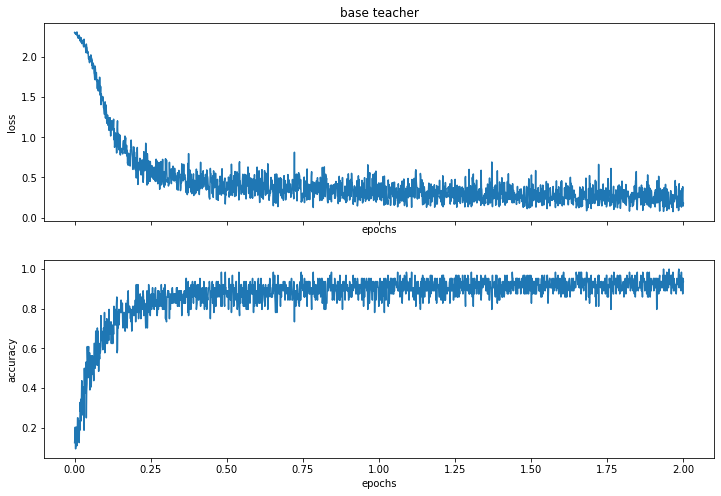

In [20]:
#train teacher network with labels
teacher_accuracies, teacher_losses = train_teacher(trainloader, optim.SGD, teacher, epochs=epochs)
#plot negative logarithmic likelihood loss vs epochs and accuracy (wrt labels) vs epochs for teacher network 
plot_loss_and_accuracy(teacher_losses, teacher_accuracies, epochs, "teacher")

EPOCH: 0



Training loss: 0.5198331726973118
EPOCH: 1



Training loss: 0.2498560531624853


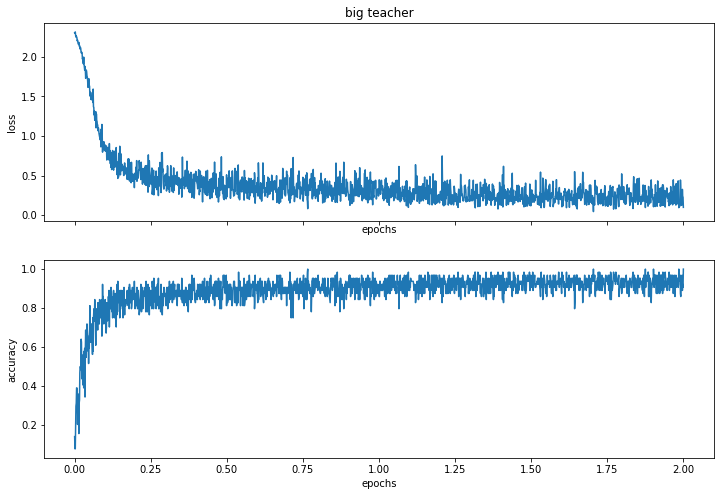

In [21]:
#train big teacher network with labels
big_teacher_accuracies, big_teacher_losses = train_teacher(trainloader, optim.SGD, big_teacher, epochs=epochs)
#plot negative logarithmic likelihood loss vs epochs and accuracy (wrt labels) vs epochs for big teacher network 
plot_loss_and_accuracy(big_teacher_losses, big_teacher_accuracies, epochs, "big teacher")

EPOCH: 0



Training loss: 2.9004748917337673
EPOCH: 1



Training loss: 0.6606223760828026


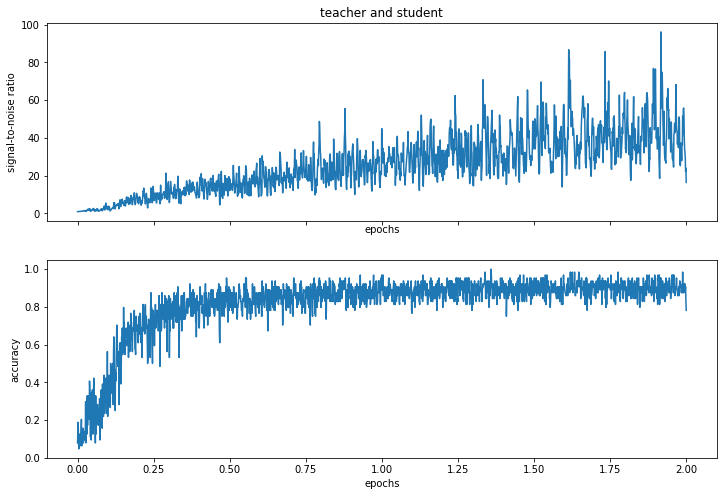

In [22]:
#create untrained student network
student_0 = make_student()
#train student network with teacher network's output
accuracies_wrt_labels_ts, accuracies_wrt_teacher_ts, losses_wrt_teacher_ts, signal_to_noise_ratio_ts = train_student_against_teacher(
    trainloader, optim.SGD, teacher, student_0, epochs=epochs)
#plot signal to noise ratio (wrt teacher network's output) vs epochs and accuracy (wrt labels) vs epochs for student network 
plot_snr_and_accuracy(signal_to_noise_ratio_ts, accuracies_wrt_labels_ts, epochs, "teacher and student")

EPOCH: 0



Training loss: 5.721185726143404
EPOCH: 1



Training loss: 3.157352581715533


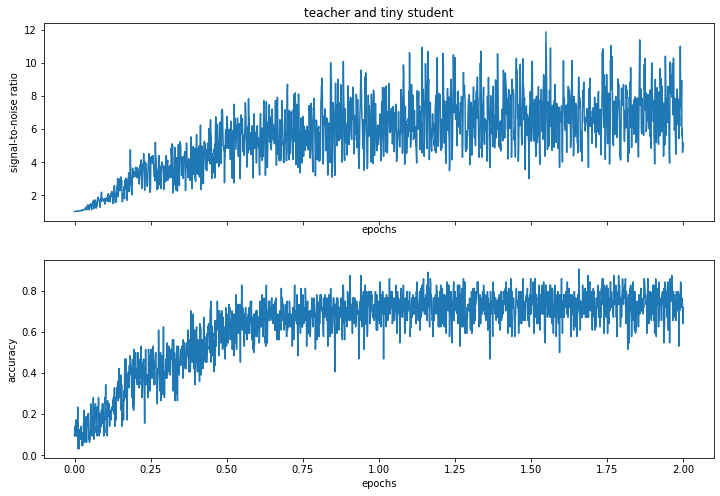

In [23]:
#create untrained tiny student network
tiny_student_0 = make_tiny_student()
#train tiny student network with teacher network's output
accuracies_wrt_labels_tts, accuracies_wrt_teacher_tts, losses_wrt_teacher_tts, signal_to_noise_ratio_tts = train_student_against_teacher(trainloader, optim.SGD, teacher, tiny_student_0, epochs=epochs)
#plot signal to noise ratio (wrt teacher network's output) vs epochs and accuracy (wrt labels) vs epochs for tiny student network
plot_snr_and_accuracy(signal_to_noise_ratio_tts, accuracies_wrt_labels_tts, epochs, "teacher and tiny student")

EPOCH: 0



Training loss: 3.148661720409576
EPOCH: 1



Training loss: 0.8053822391894835


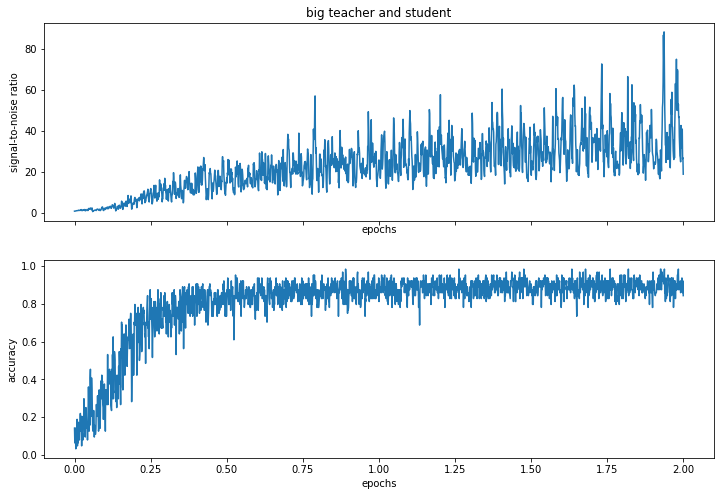

In [24]:
#create untrained student network
student_1 = make_student()
#train student network with big teacher network's output
accuracies_wrt_labels_bts, accuracies_wrt_teacher_bts, losses_wrt_teacher_bts, signal_to_noise_ratio_bts = train_student_against_teacher(trainloader, optim.SGD, big_teacher, student_1, epochs=epochs)
#plot signal to noise ratio (wrt big teacher network's output) vs epochs and accuracy (wrt labels) vs epochs for student network 
plot_snr_and_accuracy(signal_to_noise_ratio_bts, accuracies_wrt_labels_bts, epochs, "big teacher and student")

EPOCH: 0



Training loss: 6.867374597581973
EPOCH: 1



Training loss: 5.126171957709388


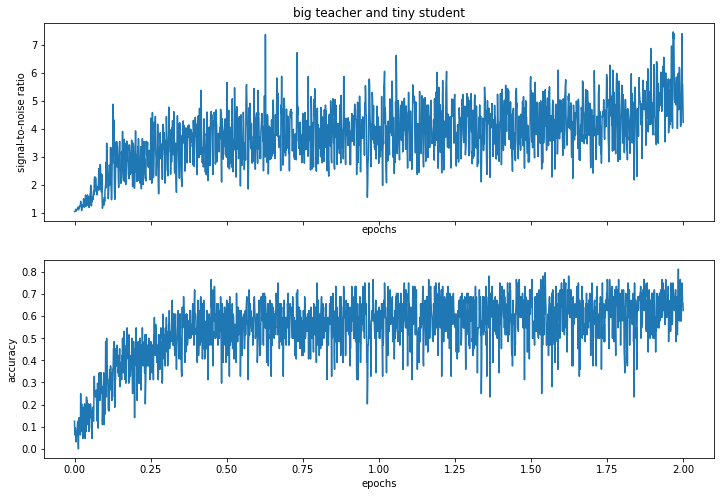

In [25]:
#create untrained tiny student network
tiny_student_1 = make_tiny_student()
#train tiny student network with big teacher network's output
accuracies_wrt_labels_btts, accuracies_wrt_teacher_btts, losses_wrt_teacher_btts, signal_to_noise_ratio_btts = train_student_against_teacher(trainloader, optim.SGD, big_teacher, tiny_student_1, epochs=epochs)
#plot signal to noise ratio (wrt big teacher network's output) vs epochs and accuracy (wrt labels) vs epochs for tiny student network
plot_snr_and_accuracy(signal_to_noise_ratio_btts, accuracies_wrt_labels_btts, epochs, "big teacher and tiny student")

In [26]:
#create untrained student network
student_2 = make_student()

In [27]:
#create untrained tiny student network
tiny_student_2 = make_tiny_student()

EPOCH: 0



Training loss: 0.713853204253513
EPOCH: 1



Training loss: 0.31398302697932035


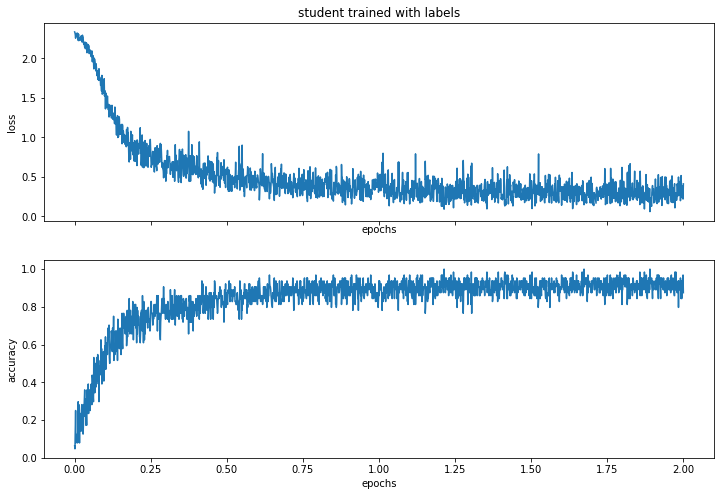

In [28]:
#train student network with labels
student_accuracies, student_losses = train_student_against_labels(trainloader, optim.SGD, student_2, epochs=epochs)
#plot negative logarithmic likelihood loss vs epochs and accuracy (wrt labels) vs epochs for student network 
plot_loss_and_accuracy(student_losses, student_accuracies, epochs, "student trained with labels")

EPOCH: 0



Training loss: 0.9597015996922308
EPOCH: 1



Training loss: 0.4597317020236048


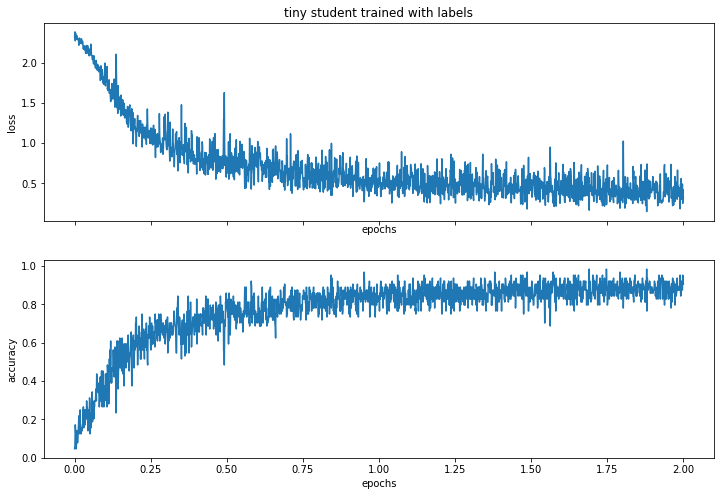

In [29]:
#train tiny student network with labels
tiny_student_accuracies, tiny_student_losses = train_student_against_labels(trainloader, optim.SGD, tiny_student_2, epochs=epochs)
#plot negative logarithmic likelihood loss vs epochs and accuracy (wrt labels) vs epochs for tiny student network 
plot_loss_and_accuracy(tiny_student_losses, tiny_student_accuracies, epochs, "tiny student trained with labels")

In [20]:
# Initialise list of tiny student networks
list_tinystudentnetworks = []

# Train 100 independent tiny student networks against labels
for count in range(100):
    tiny_student_i = make_tiny_student()
    #train tiny student network with labels
    tiny_student_i_accuracies, tiny_student_i_losses = train_student_against_labels(minibatchtrainloader, optim.SGD, 
                                                                                tiny_student_i, epochs=2)
    #list_tinystudentaccuracies.append(tiny_student_i_accuracies)
    #list_tinystudentlosses.append(tiny_student_i_losses)
    list_tinystudentnetworks.append(tiny_student_i)

EPOCH: 0



Training loss: 1.2292945713503782
EPOCH: 1



Training loss: 0.559275719307379
EPOCH: 0



Training loss: 1.059319950878493
EPOCH: 1



Training loss: 0.49799580003089233
EPOCH: 0



Training loss: 1.1446678493577025
EPOCH: 1



Training loss: 0.685022004345841
EPOCH: 0



Training loss: 1.0668501011979605
EPOCH: 1



Training loss: 0.5043237777883565
EPOCH: 0



Training loss: 1.3552206293352123
EPOCH: 1



Training loss: 0.706755850201985
EPOCH: 0



Training loss: 1.1715105255402483
EPOCH: 1



Training loss: 0.7048510330191045
EPOCH: 0



Training loss: 1.1075877671175673
EPOCH: 1



Training loss: 0.5568367415177289
EPOCH: 0



Training loss: 1.252402682103582
EPOCH: 1



Training loss: 0.6503980129258211
EPOCH: 0



Training loss: 0.9884817520502025
EPOCH: 1



Training loss: 0.4656339954497463
EPOCH: 0



Training loss: 1.4893290481206451
EPOCH: 1



Training loss: 0.5939123634654068
EPOCH: 0



Training loss: 1.0639830319357833
EPOCH: 1



Training loss: 0.5350259455727108
EPOCH: 0



Training loss: 1.8968703506597833
EPOCH: 1



Training loss: 1.2479306953166849
EPOCH: 0



Training loss: 1.1727214750132835
EPOCH: 1



Training loss: 0.520189291616874
EPOCH: 0



Training loss: 1.2209027740619838
EPOCH: 1



Training loss: 0.574285337014366
EPOCH: 0



Training loss: 1.2500379989777546
EPOCH: 1



Training loss: 0.6370139305334864
EPOCH: 0



Training loss: 1.1639111080784788
EPOCH: 1



Training loss: 0.6953404080003563
EPOCH: 0



Training loss: 1.0349209224745664
EPOCH: 1



Training loss: 0.5392452193888774
EPOCH: 0



Training loss: 1.257180270260331
EPOCH: 1



Training loss: 0.5474468797349981
EPOCH: 0



Training loss: 1.4146530944655444
EPOCH: 1



Training loss: 0.7016771919945918
EPOCH: 0



Training loss: 1.2972882806238082
EPOCH: 1



Training loss: 0.7656988158409022
EPOCH: 0



Training loss: 1.4292620049992095
EPOCH: 1



Training loss: 0.8648746336446896
EPOCH: 0



Training loss: 1.2907728027306131
EPOCH: 1



Training loss: 0.6560646448848344
EPOCH: 0



Training loss: 1.2579059392086733
EPOCH: 1



Training loss: 0.5871604859892493
EPOCH: 0



Training loss: 1.9882426146251053
EPOCH: 1



Training loss: 1.82209947215977
EPOCH: 0



Training loss: 1.225827919394731
EPOCH: 1



Training loss: 0.6663782777689667
EPOCH: 0



Training loss: 1.069994704905095
EPOCH: 1



Training loss: 0.523737790217913
EPOCH: 0



Training loss: 1.16379287321049
EPOCH: 1



Training loss: 0.5929273547711911
EPOCH: 0



Training loss: 1.0865273353006286
EPOCH: 1



Training loss: 0.5504801013608223
EPOCH: 0



Training loss: 1.0675160543306041
EPOCH: 1



Training loss: 0.5352230267420507
EPOCH: 0



Training loss: 1.5681970905520515
EPOCH: 1



Training loss: 0.9957673673563675
EPOCH: 0



Training loss: 1.0680125974960673
EPOCH: 1



Training loss: 0.4931040919824704
EPOCH: 0



Training loss: 1.033687810240778
EPOCH: 1



Training loss: 0.47990520412860904
EPOCH: 0



Training loss: 1.7042021328198123
EPOCH: 1



Training loss: 1.1697306090326451
EPOCH: 0



Training loss: 0.9509173874407689
EPOCH: 1



Training loss: 0.5126300685600177
EPOCH: 0



Training loss: 1.191157428631142
EPOCH: 1



Training loss: 0.5131423381854222
EPOCH: 0



Training loss: 1.473994046068395
EPOCH: 1



Training loss: 0.7212610714661796
EPOCH: 0



Training loss: 1.1799060230824485
EPOCH: 1



Training loss: 0.5592900761790367
EPOCH: 0



Training loss: 1.2538513789680212
EPOCH: 1



Training loss: 0.71644400308
EPOCH: 0



Training loss: 1.0031169037193632
EPOCH: 1



Training loss: 0.5220995551582847
EPOCH: 0



Training loss: 1.0386985941355162
EPOCH: 1



Training loss: 0.49679393496022806
EPOCH: 0



Training loss: 1.611847631204357
EPOCH: 1



Training loss: 1.1733872006569843
EPOCH: 0



Training loss: 1.413223030534126
EPOCH: 1



Training loss: 0.7692791293107116
EPOCH: 0



Training loss: 1.140146992608174
EPOCH: 1



Training loss: 0.5032523708906509
EPOCH: 0



Training loss: 0.9457217835541218
EPOCH: 1



Training loss: 0.4681601551041674
EPOCH: 0



Training loss: 1.0898516032932155
EPOCH: 1



Training loss: 0.5242393526282392
EPOCH: 0



Training loss: 1.1818947196324496
EPOCH: 1



Training loss: 0.6627248239669719
EPOCH: 0



Training loss: 1.1697049806240016
EPOCH: 1



Training loss: 0.5855492527074397
EPOCH: 0



Training loss: 1.0903792463258895
EPOCH: 1



Training loss: 0.5675817454642833
EPOCH: 0



Training loss: 1.0779035219442108
EPOCH: 1



Training loss: 0.48293947854212355
EPOCH: 0



Training loss: 1.1989445662828906
EPOCH: 1



Training loss: 0.6698610790248619
EPOCH: 0



Training loss: 1.040495997775338
EPOCH: 1



Training loss: 0.49490930489512647
EPOCH: 0



Training loss: 1.318685337011494
EPOCH: 1



Training loss: 0.591595765592447
EPOCH: 0



Training loss: 1.2610965482016872
EPOCH: 1



Training loss: 0.5581784465832751
EPOCH: 0



Training loss: 1.1974290423174656
EPOCH: 1



Training loss: 0.5854991856160194
EPOCH: 0



Training loss: 1.363057937830496
EPOCH: 1



Training loss: 0.6273567060163534
EPOCH: 0



Training loss: 0.997117583971542
EPOCH: 1



Training loss: 0.5113087861395594
EPOCH: 0



Training loss: 1.0706454731825827
EPOCH: 1



Training loss: 0.5148179267070441
EPOCH: 0



Training loss: 1.2121935021648529
EPOCH: 1



Training loss: 0.49974403037890186
EPOCH: 0



Training loss: 1.2142569280382414
EPOCH: 1



Training loss: 0.6354056497309
EPOCH: 0



Training loss: 1.1672002381162603
EPOCH: 1



Training loss: 0.5145120291567561
EPOCH: 0



Training loss: 1.0803288135892037
EPOCH: 1



Training loss: 0.5419620779086786
EPOCH: 0



Training loss: 1.3267080262779936
EPOCH: 1



Training loss: 0.6426995734034825
EPOCH: 0



Training loss: 1.103021726488813
EPOCH: 1



Training loss: 0.48749674756580325
EPOCH: 0



Training loss: 1.106308864981635
EPOCH: 1



Training loss: 0.4842325539699496
EPOCH: 0



Training loss: 1.1652299659465677
EPOCH: 1



Training loss: 0.4733040166943312
EPOCH: 0



Training loss: 1.528424724078636
EPOCH: 1



Training loss: 1.0742504451193535
EPOCH: 0



Training loss: 0.9515526054828152
EPOCH: 1



Training loss: 0.5148034801424693
EPOCH: 0



Training loss: 1.321837236632162
EPOCH: 1



Training loss: 0.7105987897750411
EPOCH: 0



Training loss: 1.0531382641749087
EPOCH: 1



Training loss: 0.5425007095786808
EPOCH: 0



Training loss: 1.368728810472529
EPOCH: 1



Training loss: 0.693113445314263
EPOCH: 0



Training loss: 1.0246979752138479
EPOCH: 1



Training loss: 0.5592050821319826
EPOCH: 0



Training loss: 1.4523237245931808
EPOCH: 1



Training loss: 0.6364273298015473
EPOCH: 0



Training loss: 1.2100949945734507
EPOCH: 1



Training loss: 0.5958971949592073
EPOCH: 0



Training loss: 1.6205016191580148
EPOCH: 1



Training loss: 1.1267786187403745
EPOCH: 0



Training loss: 1.2225120181340907
EPOCH: 1



Training loss: 0.71379235857077
EPOCH: 0



Training loss: 1.1251883628462422
EPOCH: 1



Training loss: 0.5550180748740493
EPOCH: 0



Training loss: 1.6752921800369394
EPOCH: 1



Training loss: 1.2377457829045335
EPOCH: 0



Training loss: 1.1366448193343717
EPOCH: 1



Training loss: 0.5772798861235952
EPOCH: 0



Training loss: 0.9428833021696951
EPOCH: 1



Training loss: 0.4503836691506636
EPOCH: 0



Training loss: 1.3220545897987097
EPOCH: 1



Training loss: 0.7341789642313142
EPOCH: 0



Training loss: 1.0817954700702288
EPOCH: 1



Training loss: 0.5598160895044362
EPOCH: 0



Training loss: 1.2954746337333467
EPOCH: 1



Training loss: 0.6984637173762454
EPOCH: 0



Training loss: 0.9900855088729594
EPOCH: 1



Training loss: 0.541748084604486
EPOCH: 0



Training loss: 1.657041869438025
EPOCH: 1



Training loss: 1.1631475101147633
EPOCH: 0



Training loss: 1.1938223741583225
EPOCH: 1



Training loss: 0.5608989896931882
EPOCH: 0



Training loss: 1.6977898076907405
EPOCH: 1



Training loss: 1.1531971425517027
EPOCH: 0



Training loss: 1.1289566852517727
EPOCH: 1



Training loss: 0.5716750473101765
EPOCH: 0



Training loss: 1.3851205397770603
EPOCH: 1



Training loss: 0.5174956407501246
EPOCH: 0



Training loss: 1.0959877044534378
EPOCH: 1



Training loss: 0.544179359002154
EPOCH: 0



Training loss: 1.2630134479069253
EPOCH: 1



Training loss: 0.7474699604676477
EPOCH: 0



Training loss: 1.0789760451581178
EPOCH: 1



Training loss: 0.5130551455498759
EPOCH: 0



Training loss: 1.580264890943763
EPOCH: 1



Training loss: 0.7885055132766268
EPOCH: 0



Training loss: 1.3233919348289718
EPOCH: 1



Training loss: 0.6145663232342012
EPOCH: 0



Training loss: 1.4773416241476023
EPOCH: 1



Training loss: 0.8182109078046864
EPOCH: 0



Training loss: 1.1313113776097166
EPOCH: 1



Training loss: 0.5961437720511513
EPOCH: 0



Training loss: 1.1052996251247584
EPOCH: 1



Training loss: 0.49862607862395264
EPOCH: 0



Training loss: 1.6821629051714817
EPOCH: 1



Training loss: 0.9098521931402719
EPOCH: 0



Training loss: 1.087311232649187
EPOCH: 1



Training loss: 0.54026129473247
EPOCH: 0



Training loss: 1.2657935065882546
EPOCH: 1



Training loss: 0.5512776126834884
EPOCH: 0



Training loss: 1.0590106266965744
EPOCH: 1



Training loss: 0.5632149153458539


In [21]:
# Initialise list of accuracies of the tiny student networks
list_tinystudentaccuracies_wholebatch = []

#Obtain accuracies for the 100 tiny student networks evaluated on whole batch.
for i in range(len(list_tinystudentnetworks)):
    tiny_student_accuracies_wholebatch = test_network_against_labels(wholebatchtrainloader, list_tinystudentnetworks[i], epochs=1)
    list_tinystudentaccuracies_wholebatch.append(tiny_student_accuracies_wholebatch[0])
    
print(list_tinystudentaccuracies_wholebatch)

EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



[0.8729, 0.8366, 0.6758333333333333, 0.8217666666666666, 0.8186, 0.8101166666666667, 0.8820666666666667, 0.8385, 0.8878333333333334, 0.8625166666666667, 0.86395, 0.4427333333333333, 0.8518, 0.8607, 0.85475, 0.83105, 0.8731166666666667, 0.8691166666666666, 0.84725, 0.8203, 0.8219333333333333, 0.8331833333333334, 0.79255, 0.29846666666666666, 0.85155, 0.8741666666666666, 0.8382166666666667, 0.8439833333333333, 0.86855, 0.7346666666666667, 0.8673166666666666, 0.8815, 0.6935666666666667, 0.88565, 0.8757833333333334, 0.8298666666666666, 0.87825, 0.77645, 0.8256166666666667, 0.8771, 0.66695, 0.8170333333333333, 0.86595, 0.8793166666666666, 0.8526666666666667, 0.8427, 0.8107833333333333, 0.8397666666666667, 0.8861666666666667, 0.8230833333333333, 0.8677166666666667, 0.8403333333333334, 0.88145, 0.8644666666666667, 0.8818333333333334, 0.8863833333333333, 0.8544333333333334, 0.8104, 0.8637666666666667, 0.8331166666666666, 0.8600166666666667, 0.86665, 0.8893333333333333, 0.86605, 0.887333333333

In [22]:
# Initialise list of accuracies of the tiny student networks
list_tinystudentaccuracies_test = []

#Obtain accuracies for the 100 tiny student networks run on testing batch.
for i in range(len(list_tinystudentnetworks)):
    tiny_student_accuracies_test = test_network_against_labels(testloader, list_tinystudentnetworks[i], epochs=1)
    list_tinystudentaccuracies_test.append(tiny_student_accuracies_test[0])
    
print(list_tinystudentaccuracies_test)

EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



[0.8757, 0.837, 0.6838, 0.827, 0.8271, 0.812, 0.8809, 0.8422, 0.8892, 0.8676, 0.8691, 0.4443, 0.855, 0.8614, 0.8584, 0.8321, 0.8723, 0.8696, 0.8389, 0.8174, 0.8189, 0.8382, 0.7986, 0.3062, 0.8581, 0.8752, 0.8368, 0.8442, 0.8706, 0.7367, 0.8666, 0.8743, 0.6981, 0.8863, 0.8786, 0.8321, 0.8773, 0.7816, 0.8255, 0.8736, 0.6646, 0.817, 0.8707, 0.8836, 0.8586, 0.8476, 0.8167, 0.8395, 0.8929, 0.8334, 0.8717, 0.842, 0.8798, 0.871, 0.8858, 0.8905, 0.861, 0.8143, 0.8646, 0.8349, 0.8629, 0.872, 0.8894, 0.8603, 0.8881, 0.7405, 0.8681, 0.8485, 0.8248, 0.8481, 0.8632, 0.8477, 0.8792, 0.635, 0.8335, 0.8761, 0.5949, 0.8335, 0.886, 0.7635, 0.865, 0.7593, 0.8718, 0.7354, 0.7616, 0.6438, 0.8683, 0.8875, 0.8685, 0.8063, 0.8571, 0.8089, 0.8745, 0.7318, 0.8655, 0.8875, 0.7704, 0.8815, 0.8685, 0.8828]


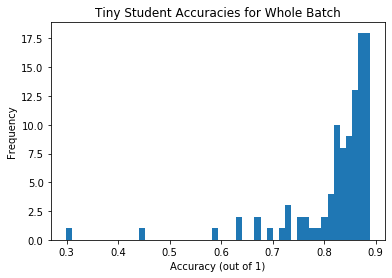

In [23]:
plt.hist(list_tinystudentaccuracies_wholebatch, bins = 50)
plt.xlabel("Accuracy (out of 1)")
plt.ylabel("Frequency")
plt.title('Tiny Student Accuracies for Whole Batch')
plt.show()

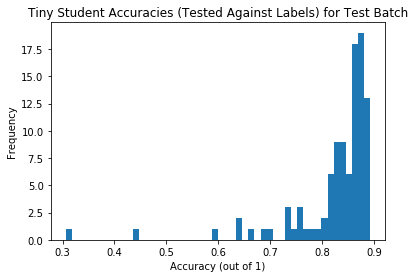

In [24]:
plt.hist(list_tinystudentaccuracies_test, bins = 50)
plt.xlabel("Accuracy (out of 1)")
plt.ylabel("Frequency")
plt.title('Tiny Student Accuracies (Tested Against Labels) for Test Batch')
plt.show()

In [25]:
# Build a feed-forward network for the teacher.
teacher = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

#train teacher network with labels
teacher_accuracies_1, teacher_losses_1 = train_teacher(trainloader, optim.SGD, teacher, epochs=2)

# Initialise list of tiny student networks
list_tinystudentnetworks_1 = []

# Train 100 independent tiny student networks against output of teacher network
for counts in range(100):
    tiny_student_j = make_tiny_student()
    #train tiny student network with output of teacher network
    tiny_student_j_accuracies_wrt_labels, tiny_student_j_accuracies_wrt_teacher, tiny_student_j_losses_wrt_teacher, tiny_student_j_snr = train_student_against_teacher(trainloader, optim.SGD, teacher, tiny_student_j, epochs=2)
    
    list_tinystudentnetworks_1.append(tiny_student_j)

EPOCH: 0



Training loss: 0.6135114842434046
EPOCH: 1



Training loss: 0.27801086821122717
EPOCH: 0



Training loss: 6.706186166450159
EPOCH: 1



Training loss: 3.7817744713093933
EPOCH: 0



Training loss: 6.733127402852594
EPOCH: 1



Training loss: 3.6730619963806577
EPOCH: 0



Training loss: 8.359396767514601
EPOCH: 1



Training loss: 5.339159932726227
EPOCH: 0



Training loss: 5.197028942199658
EPOCH: 1



Training loss: 3.2328763271191483
EPOCH: 0



Training loss: 5.988579649660887
EPOCH: 1



Training loss: 3.6517789612955123
EPOCH: 0



Training loss: 6.272844273398426
EPOCH: 1



Training loss: 3.858448593601235
EPOCH: 0



Training loss: 7.339394752659015
EPOCH: 1



Training loss: 5.0682221473152955
EPOCH: 0



Training loss: 7.617573454690132
EPOCH: 1



Training loss: 5.22818947041721
EPOCH: 0



Training loss: 6.0972480400284725
EPOCH: 1



Training loss: 3.4833508895150125
EPOCH: 0



Training loss: 9.086490623986544
EPOCH: 1



Training loss: 5.4142841476875585
EPOCH: 0



Training loss: 8.166769359157538
EPOCH: 1



Training loss: 5.315423330518483
EPOCH: 0



Training loss: 6.7751606115654335
EPOCH: 1



Training loss: 3.507316346361693
EPOCH: 0



Training loss: 7.981450059012309
EPOCH: 1



Training loss: 5.501527217405437
EPOCH: 0



Training loss: 5.292038913983018
EPOCH: 1



Training loss: 3.374897728596669
EPOCH: 0



Training loss: 7.499459633695037
EPOCH: 1



Training loss: 5.283558288108566
EPOCH: 0



Training loss: 8.608480510681169
EPOCH: 1



Training loss: 5.175801626400653
EPOCH: 0



Training loss: 6.242314633530086
EPOCH: 1



Training loss: 3.6480440793515267
EPOCH: 0



Training loss: 5.696448004322011
EPOCH: 1



Training loss: 3.5495821913676475
EPOCH: 0



Training loss: 9.644889054776256
EPOCH: 1



Training loss: 6.854875802739596
EPOCH: 0



Training loss: 5.959719602487235
EPOCH: 1



Training loss: 3.448897963520815
EPOCH: 0



Training loss: 5.888556531751588
EPOCH: 1



Training loss: 3.536860858707794
EPOCH: 0



Training loss: 6.700526823112959
EPOCH: 1



Training loss: 3.911469565017391
EPOCH: 0



Training loss: 7.899018927169507
EPOCH: 1



Training loss: 4.05439490372184
EPOCH: 0



Training loss: 8.653547340364598
EPOCH: 1



Training loss: 4.9852330448276705
EPOCH: 0



Training loss: 6.965401277104929
EPOCH: 1



Training loss: 5.004847885703227
EPOCH: 0



Training loss: 8.48546999044764
EPOCH: 1



Training loss: 4.040022214592647
EPOCH: 0



Training loss: 5.886006955398933
EPOCH: 1



Training loss: 3.8092792267992555
EPOCH: 0



Training loss: 7.069267538056445
EPOCH: 1



Training loss: 5.421227016936996
EPOCH: 0



Training loss: 7.855396806304134
EPOCH: 1



Training loss: 5.323285473435164
EPOCH: 0



Training loss: 7.381869646786118
EPOCH: 1



Training loss: 5.165976593489332
EPOCH: 0



Training loss: 8.893870574324879
EPOCH: 1



Training loss: 5.590068760711247
EPOCH: 0



Training loss: 12.159023916289241
EPOCH: 1



Training loss: 11.390305443867437
EPOCH: 0



Training loss: 6.38697936870396
EPOCH: 1



Training loss: 3.4942170539136126
EPOCH: 0



Training loss: 7.375858864804575
EPOCH: 1



Training loss: 5.125385947318982
EPOCH: 0



Training loss: 7.436008883945978
EPOCH: 1



Training loss: 5.494899940897406
EPOCH: 0



Training loss: 5.8837507640375
EPOCH: 1



Training loss: 3.5950254006172293
EPOCH: 0



Training loss: 8.942037835049986
EPOCH: 1



Training loss: 3.6669795464859334
EPOCH: 0



Training loss: 7.218741371687542
EPOCH: 1



Training loss: 4.0185690251494774
EPOCH: 0



Training loss: 6.411369835389957
EPOCH: 1



Training loss: 4.110015918959433
EPOCH: 0



Training loss: 6.734025779563481
EPOCH: 1



Training loss: 4.213536013418169
EPOCH: 0



Training loss: 6.533032604372069
EPOCH: 1



Training loss: 4.278062174315138
EPOCH: 0



Training loss: 6.976868049676485
EPOCH: 1



Training loss: 3.7476163563697833
EPOCH: 0



Training loss: 7.2541594533269596
EPOCH: 1



Training loss: 4.891320671608199
EPOCH: 0



Training loss: 6.469418455288609
EPOCH: 1



Training loss: 3.3779774268807126
EPOCH: 0



Training loss: 5.9806857426791815
EPOCH: 1



Training loss: 3.7455224088514285
EPOCH: 0



Training loss: 5.518623052375403
EPOCH: 1



Training loss: 3.4618596374861466
EPOCH: 0



Training loss: 8.66823263768194
EPOCH: 1



Training loss: 5.577477929180365
EPOCH: 0



Training loss: 6.6418087103727785
EPOCH: 1



Training loss: 4.356835593546886
EPOCH: 0



Training loss: 8.068215608596802
EPOCH: 1



Training loss: 5.502247126371876
EPOCH: 0



Training loss: 5.646505469706521
EPOCH: 1



Training loss: 3.6746536788147397
EPOCH: 0



Training loss: 8.48928648195287
EPOCH: 1



Training loss: 4.59304008072119
EPOCH: 0



Training loss: 6.550409898829105
EPOCH: 1



Training loss: 3.3636081749950644
EPOCH: 0



Training loss: 5.946500933754927
EPOCH: 1



Training loss: 3.4545942217048045
EPOCH: 0



Training loss: 7.738694719922568
EPOCH: 1



Training loss: 4.67172197822823
EPOCH: 0



Training loss: 9.48050193186762
EPOCH: 1



Training loss: 8.279427471953923
EPOCH: 0



Training loss: 5.464072707619494
EPOCH: 1



Training loss: 3.619496475913123
EPOCH: 0



Training loss: 5.6746597183284475
EPOCH: 1



Training loss: 3.4507079670932503
EPOCH: 0



Training loss: 5.844909622470961
EPOCH: 1



Training loss: 3.3991573680438467
EPOCH: 0



Training loss: 9.161296565395428
EPOCH: 1



Training loss: 5.305680585822571
EPOCH: 0



Training loss: 5.597591281953905
EPOCH: 1



Training loss: 3.385989773502228
EPOCH: 0



Training loss: 5.666745426812406
EPOCH: 1



Training loss: 3.551464227471016
EPOCH: 0



Training loss: 7.224187725388419
EPOCH: 1



Training loss: 5.225504623547292
EPOCH: 0



Training loss: 6.829927850125441
EPOCH: 1



Training loss: 4.5633949854734865
EPOCH: 0



Training loss: 6.381037980000348
EPOCH: 1



Training loss: 3.354121932215782
EPOCH: 0



Training loss: 7.474613523432441
EPOCH: 1



Training loss: 4.679319699181677
EPOCH: 0



Training loss: 6.731164357301269
EPOCH: 1



Training loss: 3.752989971307295
EPOCH: 0



Training loss: 9.378249014364377
EPOCH: 1



Training loss: 8.169330309194796
EPOCH: 0



Training loss: 6.35433657794619
EPOCH: 1



Training loss: 3.8272845399405147
EPOCH: 0



Training loss: 6.3316793340101425
EPOCH: 1



Training loss: 4.513190502551065
EPOCH: 0



Training loss: 12.488397182432065
EPOCH: 1



Training loss: 11.773147836168691
EPOCH: 0



Training loss: 5.21443418831205
EPOCH: 1



Training loss: 3.414610606012568
EPOCH: 0



Training loss: 6.3649967606387925
EPOCH: 1



Training loss: 4.0994263808610345
EPOCH: 0



Training loss: 6.125006283015839
EPOCH: 1



Training loss: 3.9191450785472193
EPOCH: 0



Training loss: 6.875362952380801
EPOCH: 1



Training loss: 4.195004732878224
EPOCH: 0



Training loss: 5.8790785834225
EPOCH: 1



Training loss: 3.4927437203779403
EPOCH: 0



Training loss: 7.156400099492022
EPOCH: 1



Training loss: 5.290080660187614
EPOCH: 0



Training loss: 6.439988603724092
EPOCH: 1



Training loss: 3.5093855949353054
EPOCH: 0



Training loss: 5.240917967326605
EPOCH: 1



Training loss: 3.207929462257987
EPOCH: 0



Training loss: 15.468351187228139
EPOCH: 1



Training loss: 15.301530439462235
EPOCH: 0



Training loss: 8.139073563791287
EPOCH: 1



Training loss: 5.6747417693961655
EPOCH: 0



Training loss: 5.760519804222497
EPOCH: 1



Training loss: 3.282192974456592
EPOCH: 0



Training loss: 6.030375244266697
EPOCH: 1



Training loss: 3.561188969784962
EPOCH: 0



Training loss: 6.22028296436074
EPOCH: 1



Training loss: 3.285664230013199
EPOCH: 0



Training loss: 6.4768030096981315
EPOCH: 1



Training loss: 4.059081672351243
EPOCH: 0



Training loss: 7.208683675031926
EPOCH: 1



Training loss: 4.488950246941052
EPOCH: 0



Training loss: 5.725010150531207
EPOCH: 1



Training loss: 3.3867316741679017
EPOCH: 0



Training loss: 6.95386193530646
EPOCH: 1



Training loss: 3.713339258612854
EPOCH: 0



Training loss: 5.175703996788464
EPOCH: 1



Training loss: 3.3394874860482937
EPOCH: 0



Training loss: 8.34848077134537
EPOCH: 1



Training loss: 5.201055641621669
EPOCH: 0



Training loss: 6.346495142877737
EPOCH: 1



Training loss: 3.978668563655699
EPOCH: 0



Training loss: 9.461589699360863
EPOCH: 1



Training loss: 5.601068879241374
EPOCH: 0



Training loss: 7.353651930274231
EPOCH: 1



Training loss: 4.403993916409864
EPOCH: 0



Training loss: 6.982934062414841
EPOCH: 1



Training loss: 3.539585843523428
EPOCH: 0



Training loss: 6.904718572396968
EPOCH: 1



Training loss: 3.600197083151925
EPOCH: 0



Training loss: 7.778073202064043
EPOCH: 1



Training loss: 5.351077535005012
EPOCH: 0



Training loss: 6.80490510550135
EPOCH: 1



Training loss: 3.9084461541064006
EPOCH: 0



Training loss: 5.909681019498341
EPOCH: 1



Training loss: 3.48807253842669
EPOCH: 0



Training loss: 15.539819338174263
EPOCH: 1



Training loss: 15.30214962318762
EPOCH: 0



Training loss: 5.688254088226921
EPOCH: 1



Training loss: 3.6630418061701726
EPOCH: 0



Training loss: 15.508808656542032
EPOCH: 1



Training loss: 15.303017453598315


In [26]:
# Initialise lists of accuracies and losses of the tiny student networks
list_tinystudentaccuracies_j_test = []
#list_tinystudentlosses_j_test = []

#Obtain accuracies and losses for the 100 tiny student networks run on testing batch.
for i in range(len(list_tinystudentnetworks_1)):
    tiny_student_accuracies_j_test = test_network_against_labels(testloader, list_tinystudentnetworks_1[i], epochs=1)
    list_tinystudentaccuracies_j_test.append(tiny_student_accuracies_j_test[0])
    #tiny_student_losses_j_test = tiny_student_losses_j_test[0].detach().numpy()
    #list_tinystudentlosses_j_test.append(float(tiny_student_losses_j_test))
    
print(list_tinystudentaccuracies_j_test)
#print(list_tinystudentlosses_j_test)

EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



[0.6827, 0.7132, 0.4089, 0.731, 0.7067, 0.6757, 0.5736, 0.618, 0.6831, 0.5087, 0.5702, 0.7268, 0.5829, 0.6985, 0.6204, 0.6363, 0.7107, 0.6259, 0.47, 0.7221, 0.7374, 0.7276, 0.7048, 0.6646, 0.6356, 0.7383, 0.6393, 0.5847, 0.572, 0.6032, 0.4715, 0.1983, 0.7057, 0.6149, 0.6259, 0.708, 0.6673, 0.7063, 0.7047, 0.6679, 0.731, 0.7433, 0.7044, 0.7372, 0.7203, 0.6907, 0.5579, 0.5664, 0.5451, 0.7192, 0.6391, 0.6972, 0.7436, 0.7026, 0.4472, 0.7489, 0.7335, 0.7276, 0.7066, 0.6947, 0.6695, 0.5588, 0.7135, 0.6966, 0.714, 0.6521, 0.3537, 0.7312, 0.6916, 0.1732, 0.6641, 0.6627, 0.6439, 0.7228, 0.7203, 0.5298, 0.6673, 0.7131, 0.1032, 0.5188, 0.6741, 0.6919, 0.749, 0.684, 0.6077, 0.7361, 0.7186, 0.7296, 0.6142, 0.6943, 0.5193, 0.718, 0.7384, 0.5825, 0.5423, 0.6722, 0.7257, 0.1032, 0.6349, 0.1032]


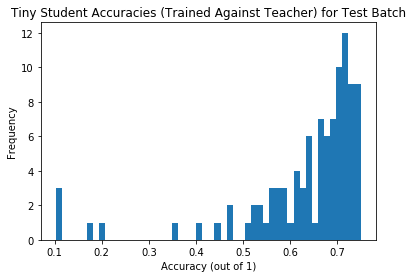

In [27]:
plt.hist(list_tinystudentaccuracies_j_test, bins = 50)
plt.xlabel("Accuracy (out of 1)")
plt.ylabel("Frequency")
plt.title('Tiny Student Accuracies (Trained Against Teacher) for Test Batch')
plt.show()

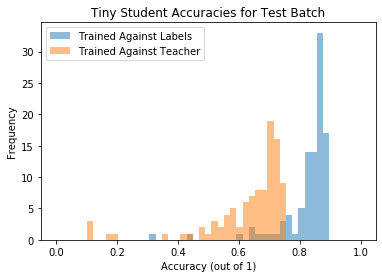

In [28]:
bins = np.linspace(0, 1, 50)

pyplot.hist(list_tinystudentaccuracies_test, bins, alpha=0.5, label='Trained Against Labels')
pyplot.hist(list_tinystudentaccuracies_j_test, bins, alpha=0.5, label='Trained Against Teacher')
pyplot.legend(loc='upper left')
plt.xlabel("Accuracy (out of 1)")
plt.ylabel("Frequency")
plt.title('Tiny Student Accuracies for Test Batch')
pyplot.show()

### Tinier Student Network

In [29]:
# Initialise list of tiny student networks
list_tinierstudentnetworks = []

# Train 100 independent tinier student networks against labels
for count in range(100):
    tinier_student_i = make_tinier_student()
    #train tiny student network with labels
    tinier_student_i_accuracies, tinier_student_i_losses = train_student_against_labels(minibatchtrainloader, optim.SGD, 
                                                                                tinier_student_i, epochs=2)
    list_tinierstudentnetworks.append(tinier_student_i)

EPOCH: 0



Training loss: 1.7187706186318956
EPOCH: 1



Training loss: 1.3562557045330625
EPOCH: 0



Training loss: 1.238251442848238
EPOCH: 1



Training loss: 0.957292209429019
EPOCH: 0



Training loss: 1.9659354149151458
EPOCH: 1



Training loss: 1.5979519778731535
EPOCH: 0



Training loss: 1.6145468776159957
EPOCH: 1



Training loss: 1.2733634217842809
EPOCH: 0



Training loss: 1.6731857948465896
EPOCH: 1



Training loss: 1.2979671896647798
EPOCH: 0



Training loss: 1.2765660535043746
EPOCH: 1



Training loss: 0.9245170745641184
EPOCH: 0



Training loss: 1.9184527394613986
EPOCH: 1



Training loss: 1.8134446516474172
EPOCH: 0



Training loss: 1.3653588662269527
EPOCH: 1



Training loss: 0.926398419939887
EPOCH: 0



Training loss: 1.962373108370726
EPOCH: 1



Training loss: 1.8041272842045277
EPOCH: 0



Training loss: 1.7859170744414015
EPOCH: 1



Training loss: 1.396943086500107
EPOCH: 0



Training loss: 2.3083391957191517
EPOCH: 1



Training loss: 2.202000240018881
EPOCH: 0



Training loss: 1.6448805013190964
EPOCH: 1



Training loss: 1.2891216872851732
EPOCH: 0



Training loss: 1.5384931936701223
EPOCH: 1



Training loss: 1.2924567066403085
EPOCH: 0



Training loss: 1.87066285734746
EPOCH: 1



Training loss: 1.3477701467237493
EPOCH: 0



Training loss: 1.975838190202774
EPOCH: 1



Training loss: 1.8308265694677195
EPOCH: 0



Training loss: 1.5380586890269443
EPOCH: 1



Training loss: 1.2281679729662978
EPOCH: 0



Training loss: 1.6306525274380437
EPOCH: 1



Training loss: 1.2672681239749324
EPOCH: 0



Training loss: 1.3314691480161793
EPOCH: 1



Training loss: 0.916457493104406
EPOCH: 0



Training loss: 1.395447542100573
EPOCH: 1



Training loss: 0.9050874074639034
EPOCH: 0



Training loss: 1.7686402956559968
EPOCH: 1



Training loss: 1.3353604406181938
EPOCH: 0



Training loss: 1.3118348897520158
EPOCH: 1



Training loss: 0.9008712752668588
EPOCH: 0



Training loss: 1.9514133472686637
EPOCH: 1



Training loss: 1.8034101947030026
EPOCH: 0



Training loss: 1.4304196019925035
EPOCH: 1



Training loss: 0.9888512304088454
EPOCH: 0



Training loss: 1.1914311622632847
EPOCH: 1



Training loss: 0.914817868455895
EPOCH: 0



Training loss: 1.2266411314895158
EPOCH: 1



Training loss: 0.9557420261887345
EPOCH: 0



Training loss: 1.422413792627961
EPOCH: 1



Training loss: 0.9385112761053195
EPOCH: 0



Training loss: 1.5866899771858125
EPOCH: 1



Training loss: 0.9548575229355013
EPOCH: 0



Training loss: 1.3899795193789102
EPOCH: 1



Training loss: 0.9163131122904291
EPOCH: 0



Training loss: 1.985682934713262
EPOCH: 1



Training loss: 1.4766712374270343
EPOCH: 0



Training loss: 1.6398859126989775
EPOCH: 1



Training loss: 1.1661372811301176
EPOCH: 0



Training loss: 1.3184942264419628
EPOCH: 1



Training loss: 1.0014057026616037
EPOCH: 0



Training loss: 1.161676603784439
EPOCH: 1



Training loss: 0.885498858019233
EPOCH: 0



Training loss: 1.50210367921573
EPOCH: 1



Training loss: 1.2859548386861521
EPOCH: 0



Training loss: 1.504499821774741
EPOCH: 1



Training loss: 1.2573910860110447
EPOCH: 0



Training loss: 1.282852365136909
EPOCH: 1



Training loss: 0.9265750761606546
EPOCH: 0



Training loss: 2.021501386343543
EPOCH: 1



Training loss: 1.8077451030074407
EPOCH: 0



Training loss: 1.4698095125303086
EPOCH: 1



Training loss: 0.9776354111206811
EPOCH: 0



Training loss: 1.565782180600075
EPOCH: 1



Training loss: 1.011607452432738
EPOCH: 0



Training loss: 1.6919617740584334
EPOCH: 1



Training loss: 1.1152946328811808
EPOCH: 0



Training loss: 1.9696460898751136
EPOCH: 1



Training loss: 1.8300918833787507
EPOCH: 0



Training loss: 1.5809484468594288
EPOCH: 1



Training loss: 1.2415761469777968
EPOCH: 0



Training loss: 1.4358737779451585
EPOCH: 1



Training loss: 0.903795068452099
EPOCH: 0



Training loss: 1.6235447869117834
EPOCH: 1



Training loss: 1.3232783313626166
EPOCH: 0



Training loss: 1.411553445528311
EPOCH: 1



Training loss: 0.8875548096099642
EPOCH: 0



Training loss: 1.6739796586890718
EPOCH: 1



Training loss: 1.3011714335062357
EPOCH: 0



Training loss: 1.9854385815957971
EPOCH: 1



Training loss: 1.8272440934232048
EPOCH: 0



Training loss: 1.2758955983464906
EPOCH: 1



Training loss: 0.8261899773373025
EPOCH: 0



Training loss: 1.5801516678541707
EPOCH: 1



Training loss: 0.9562944705044029
EPOCH: 0



Training loss: 2.1542194659776017
EPOCH: 1



Training loss: 1.8178164488725317
EPOCH: 0



Training loss: 1.5525118782322036
EPOCH: 1



Training loss: 1.2546083028001318
EPOCH: 0



Training loss: 1.6471952732437964
EPOCH: 1



Training loss: 1.199238029115998
EPOCH: 0



Training loss: 1.8376341572702566
EPOCH: 1



Training loss: 1.3582215866427432
EPOCH: 0



Training loss: 1.7607041114428912
EPOCH: 1



Training loss: 1.387895658072124
EPOCH: 0



Training loss: 1.2474466915577969
EPOCH: 1



Training loss: 0.9518603258676874
EPOCH: 0



Training loss: 1.485904185820236
EPOCH: 1



Training loss: 0.902109673282485
EPOCH: 0



Training loss: 1.8260725590465927
EPOCH: 1



Training loss: 1.3802497435226115
EPOCH: 0



Training loss: 1.734747008219965
EPOCH: 1



Training loss: 1.3553349262615766
EPOCH: 0



Training loss: 1.9829871898520983
EPOCH: 1



Training loss: 1.439656490837333
EPOCH: 0



Training loss: 1.6926014336949982
EPOCH: 1



Training loss: 1.320775588946556
EPOCH: 0



Training loss: 1.3139133701827734
EPOCH: 1



Training loss: 0.888749243989428
EPOCH: 0



Training loss: 1.4394258689016168
EPOCH: 1



Training loss: 0.9575094729344219
EPOCH: 0



Training loss: 1.7626377448344281
EPOCH: 1



Training loss: 1.3080792190042385
EPOCH: 0



Training loss: 2.307539085589492
EPOCH: 1



Training loss: 2.301348328082038
EPOCH: 0



Training loss: 1.6881122137946107
EPOCH: 1



Training loss: 1.3611332250556458
EPOCH: 0



Training loss: 1.3488075247705618
EPOCH: 1



Training loss: 0.9640816219452856
EPOCH: 0



Training loss: 2.177690812900885
EPOCH: 1



Training loss: 1.8984842933317236
EPOCH: 0



Training loss: 1.9442275209721727
EPOCH: 1



Training loss: 1.698776598424037
EPOCH: 0



Training loss: 1.2555479250355823
EPOCH: 1



Training loss: 0.9286540300607173
EPOCH: 0



Training loss: 1.5506847216122186
EPOCH: 1



Training loss: 1.228320939962798
EPOCH: 0



Training loss: 1.3313350337527707
EPOCH: 1



Training loss: 0.9612300931009402
EPOCH: 0



Training loss: 1.1900506529853796
EPOCH: 1



Training loss: 0.9624931962251155
EPOCH: 0



Training loss: 1.2757264260671286
EPOCH: 1



Training loss: 0.941351729733095
EPOCH: 0



Training loss: 1.6333300133249653
EPOCH: 1



Training loss: 1.3046720851458975
EPOCH: 0



Training loss: 1.821020727472773
EPOCH: 1



Training loss: 1.3339027776392793
EPOCH: 0



Training loss: 1.7119915297290664
EPOCH: 1



Training loss: 1.3059817694270535
EPOCH: 0



Training loss: 1.691799521446228
EPOCH: 1



Training loss: 1.3379033947550159
EPOCH: 0



Training loss: 1.4109696557145637
EPOCH: 1



Training loss: 0.9233479403864855
EPOCH: 0



Training loss: 1.953141009248396
EPOCH: 1



Training loss: 1.792630043619477
EPOCH: 0



Training loss: 2.011482664516994
EPOCH: 1



Training loss: 1.8377484672867668
EPOCH: 0



Training loss: 1.3597862717312281
EPOCH: 1



Training loss: 0.880486260789798
EPOCH: 0



Training loss: 1.4832451272366651
EPOCH: 1



Training loss: 1.2618427650252384
EPOCH: 0



Training loss: 1.6341370208176977
EPOCH: 1



Training loss: 1.322840583476939
EPOCH: 0



Training loss: 1.4062182260855938
EPOCH: 1



Training loss: 0.928966377208482
EPOCH: 0



Training loss: 1.7271498010865152
EPOCH: 1



Training loss: 1.3055641820817105
EPOCH: 0



Training loss: 1.3480918326103357
EPOCH: 1



Training loss: 0.9272622025089223
EPOCH: 0



Training loss: 1.5560774250325364
EPOCH: 1



Training loss: 1.2690629475533581
EPOCH: 0



Training loss: 1.9862772103057487
EPOCH: 1



Training loss: 1.7432797350354794
EPOCH: 0



Training loss: 2.003668817629946
EPOCH: 1



Training loss: 1.4468565813259784
EPOCH: 0



Training loss: 1.6285691538345077
EPOCH: 1



Training loss: 1.2860684618512706
EPOCH: 0



Training loss: 1.9817404180193252
EPOCH: 1



Training loss: 1.8256888399754505
EPOCH: 0



Training loss: 1.6185857222786844
EPOCH: 1



Training loss: 0.9988402812592765
EPOCH: 0



Training loss: 1.129841482715566
EPOCH: 1



Training loss: 0.8415882428571868
EPOCH: 0



Training loss: 1.6690519683396638
EPOCH: 1



Training loss: 1.2887662961793098
EPOCH: 0



Training loss: 1.3535037810233101
EPOCH: 1



Training loss: 0.921472944938806
EPOCH: 0



Training loss: 2.3105308315647184
EPOCH: 1



Training loss: 2.3013434199127816
EPOCH: 0



Training loss: 1.9589953793645667
EPOCH: 1



Training loss: 1.7908499178601736
EPOCH: 0



Training loss: 1.6876951259082313
EPOCH: 1



Training loss: 1.327138768203223
EPOCH: 0



Training loss: 1.959606737343233
EPOCH: 1



Training loss: 1.7801506756973673
EPOCH: 0



Training loss: 1.3201935551822312
EPOCH: 1



Training loss: 0.8801162770307903
EPOCH: 0



Training loss: 1.6103471367598088
EPOCH: 1



Training loss: 1.255626636908761


In [30]:
# Initialise lists of accuracies and losses of the tinier student networks
list_tinierstudentaccuracies_wholebatch = []
list_tinierstudentlosses_wholebatch = []

#Obtain accuracies for the 100 tinier student networks evaluated on whole batch.
for i in range(len(list_tinierstudentnetworks)):
    tinier_student_accuracies_wholebatch = test_network_against_labels(wholebatchtrainloader, list_tinierstudentnetworks[i], epochs=1)
    list_tinierstudentaccuracies_wholebatch.append(tinier_student_accuracies_wholebatch[0])
    
print(list_tinierstudentaccuracies_wholebatch)

EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



[0.5753666666666667, 0.6955833333333333, 0.41565, 0.5458333333333333, 0.53635, 0.7388833333333333, 0.21708333333333332, 0.7097166666666667, 0.27658333333333335, 0.5428833333333334, 0.1892, 0.5461, 0.4195, 0.4730666666666667, 0.2972666666666667, 0.5885166666666667, 0.5494333333333333, 0.7216, 0.7154833333333334, 0.5341333333333333, 0.7235833333333334, 0.25571666666666665, 0.73265, 0.7103833333333334, 0.7035166666666667, 0.7043, 0.7109666666666666, 0.7412333333333333, 0.46791666666666665, 0.73165, 0.6248833333333333, 0.6961666666666667, 0.5179333333333334, 0.5344166666666667, 0.7320666666666666, 0.25801666666666667, 0.7347333333333333, 0.75795, 0.5915333333333334, 0.2694166666666667, 0.5759833333333333, 0.73185, 0.4774833333333333, 0.7677833333333334, 0.5798, 0.24761666666666668, 0.7713, 0.72605, 0.258, 0.5167833333333334, 0.6291333333333333, 0.6672, 0.5421333333333334, 0.7180333333333333, 0.6911833333333334, 0.46705, 0.4928666666666667, 0.46903333333333336, 0.52825, 0.7465, 0.749066666

In [31]:
# Initialise list of accuracies of the tinier student networks
list_tinierstudentaccuracies_test = []

#Obtain accuracies for the 100 tinier student networks run on testing batch.
for i in range(len(list_tinierstudentnetworks)):
    tinier_student_accuracies_test = test_network_against_labels(testloader, list_tinierstudentnetworks[i], epochs=1)
    list_tinierstudentaccuracies_test.append(tinier_student_accuracies_test[0])
    
print(list_tinierstudentaccuracies_test)

EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



[0.573, 0.7023, 0.4169, 0.544, 0.536, 0.7406, 0.2141, 0.7029, 0.2754, 0.5312, 0.1949, 0.5483, 0.4175, 0.4913, 0.2987, 0.5947, 0.5466, 0.7189, 0.7272, 0.5318, 0.7274, 0.2503, 0.7352, 0.7092, 0.7042, 0.7061, 0.7111, 0.7477, 0.4685, 0.7356, 0.6222, 0.7064, 0.5147, 0.5328, 0.7285, 0.2574, 0.7414, 0.7679, 0.5895, 0.2698, 0.5801, 0.7428, 0.4754, 0.7744, 0.5849, 0.2532, 0.776, 0.7293, 0.2517, 0.5072, 0.6254, 0.6656, 0.5504, 0.7204, 0.7039, 0.4709, 0.4907, 0.474, 0.5293, 0.7462, 0.7432, 0.566, 0.1135, 0.4832, 0.666, 0.2248, 0.3578, 0.7232, 0.5566, 0.7283, 0.7162, 0.7449, 0.4875, 0.5687, 0.5412, 0.4955, 0.6801, 0.274, 0.288, 0.7022, 0.563, 0.5544, 0.7286, 0.5532, 0.7317, 0.4916, 0.4521, 0.3461, 0.5062, 0.2934, 0.7284, 0.7222, 0.5739, 0.7055, 0.1135, 0.2666, 0.4933, 0.2374, 0.7515, 0.5003]


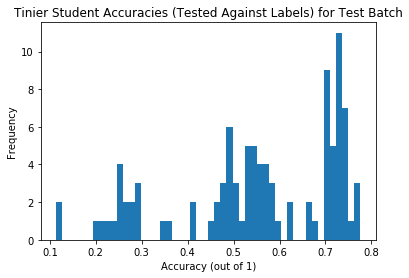

In [32]:
plt.hist(list_tinierstudentaccuracies_test, bins = 50)
plt.xlabel("Accuracy (out of 1)")
plt.ylabel("Frequency")
plt.title('Tinier Student Accuracies (Tested Against Labels) for Test Batch')
plt.show()

In [33]:
# Build a feed-forward network for the teacher.
teacher = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

#train teacher network with labels
teacher_accuracies_2, teacher_losses_2 = train_teacher(trainloader, optim.SGD, teacher, epochs=2)

# Initialise list of tinier student networks
list_tinierstudentnetworks_1 = []

# Train 100 independent tinier student networks against output of teacher network
for counts in range(100):
    tinier_student_j = make_tinier_student()
    #train tinier student network with output of teacher network
    tinier_student_j_accuracies_wrt_labels, tinier_student_j_accuracies_wrt_teacher, tinier_student_j_losses_wrt_teacher, tinier_student_j_snr = train_student_against_teacher(trainloader, optim.SGD, teacher, tinier_student_j, epochs=2)
    
    list_tinierstudentnetworks_1.append(tinier_student_j)

EPOCH: 0



Training loss: 0.6034762006102086
EPOCH: 1



Training loss: 0.29012732840836175
EPOCH: 0



Training loss: 14.514745918672476
EPOCH: 1



Training loss: 14.247991920788404
EPOCH: 0



Training loss: 14.529324622042397
EPOCH: 1



Training loss: 14.248587593086746
EPOCH: 0



Training loss: 14.543390559743463
EPOCH: 1



Training loss: 14.24779955918855
EPOCH: 0



Training loss: 11.770204384443856
EPOCH: 1



Training loss: 10.37117055128378
EPOCH: 0



Training loss: 12.942303831389209
EPOCH: 1



Training loss: 10.725920413857075
EPOCH: 0



Training loss: 14.5543794042266
EPOCH: 1



Training loss: 14.247755127929167
EPOCH: 0



Training loss: 14.498669718882677
EPOCH: 1



Training loss: 14.248494469534867
EPOCH: 0



Training loss: 14.514961644276372
EPOCH: 1



Training loss: 14.24772794719444
EPOCH: 0



Training loss: 14.559694503670308
EPOCH: 1



Training loss: 14.248935391399652
EPOCH: 0



Training loss: 14.526856185530804
EPOCH: 1



Training loss: 14.248029263543168
EPOCH: 0



Training loss: 14.540348453562396
EPOCH: 1



Training loss: 14.248441034288549
EPOCH: 0



Training loss: 11.709058010247725
EPOCH: 1



Training loss: 10.265231172667383
EPOCH: 0



Training loss: 14.521427982143248
EPOCH: 1



Training loss: 14.247514358715716
EPOCH: 0



Training loss: 14.544669507154778
EPOCH: 1



Training loss: 14.24747071337344
EPOCH: 0



Training loss: 13.694701999997788
EPOCH: 1



Training loss: 10.344254563866393
EPOCH: 0



Training loss: 14.503425270763795
EPOCH: 1



Training loss: 14.248808650319765
EPOCH: 0



Training loss: 14.470098117267145
EPOCH: 1



Training loss: 14.247499391722526
EPOCH: 0



Training loss: 14.491599759059167
EPOCH: 1



Training loss: 14.247719411910978
EPOCH: 0



Training loss: 13.872436303828062
EPOCH: 1



Training loss: 10.675986615325343
EPOCH: 0



Training loss: 11.116091205621325
EPOCH: 1



Training loss: 10.266000510787151
EPOCH: 0



Training loss: 11.993878155120655
EPOCH: 1



Training loss: 10.702841706875798
EPOCH: 0



Training loss: 14.498760551786118
EPOCH: 1



Training loss: 14.247979219025895
EPOCH: 0



Training loss: 8.554654908332743
EPOCH: 1



Training loss: 7.626497791265882
EPOCH: 0



Training loss: 11.049169458051734
EPOCH: 1



Training loss: 10.307476428017688
EPOCH: 0



Training loss: 11.869944311154168
EPOCH: 1



Training loss: 10.450693379587202
EPOCH: 0



Training loss: 11.113961188269576
EPOCH: 1



Training loss: 10.297145294482267
EPOCH: 0



Training loss: 10.894515722799403
EPOCH: 1



Training loss: 10.30721074736703
EPOCH: 0



Training loss: 14.521191767792203
EPOCH: 1



Training loss: 14.247726047979489
EPOCH: 0



Training loss: 14.554133710068172
EPOCH: 1



Training loss: 14.247663407437583
EPOCH: 0



Training loss: 14.531971864354636
EPOCH: 1



Training loss: 14.248532248458375
EPOCH: 0



Training loss: 14.51186514815796
EPOCH: 1



Training loss: 14.248048327879102
EPOCH: 0



Training loss: 11.246004151382934
EPOCH: 1



Training loss: 10.319594652667991
EPOCH: 0



Training loss: 14.561041083671391
EPOCH: 1



Training loss: 14.248862690508746
EPOCH: 0



Training loss: 14.46113114977188
EPOCH: 1



Training loss: 14.248175205198178
EPOCH: 0



Training loss: 11.903060851066606
EPOCH: 1



Training loss: 10.272831535542698
EPOCH: 0



Training loss: 14.48812204332494
EPOCH: 1



Training loss: 14.248556547835946
EPOCH: 0



Training loss: 14.503392265295423
EPOCH: 1



Training loss: 14.248629482570234
EPOCH: 0



Training loss: 14.586166912558745
EPOCH: 1



Training loss: 14.248144676436238
EPOCH: 0



Training loss: 11.172424818661167
EPOCH: 1



Training loss: 10.313258722138558
EPOCH: 0



Training loss: 14.553293792423663
EPOCH: 1



Training loss: 14.248333372795251
EPOCH: 0



Training loss: 11.604759168523207
EPOCH: 1



Training loss: 10.289589785309488
EPOCH: 0



Training loss: 11.218587299908148
EPOCH: 1



Training loss: 9.756596445783115
EPOCH: 0



Training loss: 14.509500955976149
EPOCH: 1



Training loss: 14.248098646908172
EPOCH: 0



Training loss: 8.652546171440498
EPOCH: 1



Training loss: 7.642792004257886
EPOCH: 0



Training loss: 12.015093135427056
EPOCH: 1



Training loss: 10.882671309432496
EPOCH: 0



Training loss: 11.56718306856623
EPOCH: 1



Training loss: 10.28884821304126
EPOCH: 0



Training loss: 12.01860200418338
EPOCH: 1



Training loss: 10.936578543201438
EPOCH: 0



Training loss: 14.557818225706056
EPOCH: 1



Training loss: 14.247736798674822
EPOCH: 0



Training loss: 11.310497931580045
EPOCH: 1



Training loss: 10.733133844729426
EPOCH: 0



Training loss: 11.458770321884643
EPOCH: 1



Training loss: 7.848119686915676
EPOCH: 0



Training loss: 11.151680796893675
EPOCH: 1



Training loss: 10.266100402579887
EPOCH: 0



Training loss: 11.425491144916396
EPOCH: 1



Training loss: 10.288718277457427
EPOCH: 0



Training loss: 14.481032243415491
EPOCH: 1



Training loss: 14.247138073195272
EPOCH: 0



Training loss: 14.531309486706373
EPOCH: 1



Training loss: 14.247821182584458
EPOCH: 0



Training loss: 14.550801447967984
EPOCH: 1



Training loss: 14.247889209657844
EPOCH: 0



Training loss: 14.530964909331885
EPOCH: 1



Training loss: 14.248528555766352
EPOCH: 0



Training loss: 14.512429557629485
EPOCH: 1



Training loss: 14.247197526350204
EPOCH: 0



Training loss: 11.125342647658227
EPOCH: 1



Training loss: 10.305020703435707
EPOCH: 0



Training loss: 11.270037701897529
EPOCH: 1



Training loss: 10.330634150677907
EPOCH: 0



Training loss: 14.50847577743693
EPOCH: 1



Training loss: 14.248010416783249
EPOCH: 0



Training loss: 11.996874345645214
EPOCH: 1



Training loss: 10.259470402813161
EPOCH: 0



Training loss: 11.351738527131234
EPOCH: 1



Training loss: 10.352508919071287
EPOCH: 0



Training loss: 12.221465437142834
EPOCH: 1



Training loss: 10.279669758607584
EPOCH: 0



Training loss: 11.16698870120018
EPOCH: 1



Training loss: 10.299770112230833
EPOCH: 0



Training loss: 14.527566385167495
EPOCH: 1



Training loss: 14.249200402038184
EPOCH: 0



Training loss: 13.812781630802764
EPOCH: 1



Training loss: 10.354616311567424
EPOCH: 0



Training loss: 12.112664776824431
EPOCH: 1



Training loss: 10.74946601558596
EPOCH: 0



Training loss: 10.97323128104464
EPOCH: 1



Training loss: 10.299617128839879
EPOCH: 0



Training loss: 14.54420428184558
EPOCH: 1



Training loss: 14.247740525934995
EPOCH: 0



Training loss: 11.104205362324013
EPOCH: 1



Training loss: 10.29476300892291
EPOCH: 0



Training loss: 14.49855550875796
EPOCH: 1



Training loss: 14.247522880781942
EPOCH: 0



Training loss: 14.473193770532669
EPOCH: 1



Training loss: 14.24878436822627
EPOCH: 0



Training loss: 11.258176566695354
EPOCH: 1



Training loss: 10.272304326486486
EPOCH: 0



Training loss: 14.554631091892592
EPOCH: 1



Training loss: 14.247833545782418
EPOCH: 0



Training loss: 14.516844021486067
EPOCH: 1



Training loss: 14.248487069916878
EPOCH: 0



Training loss: 14.520868439664211
EPOCH: 1



Training loss: 14.24892985846188
EPOCH: 0



Training loss: 11.483805967546475
EPOCH: 1



Training loss: 10.38100276776214
EPOCH: 0



Training loss: 11.49404307672464
EPOCH: 1



Training loss: 10.271202693361717
EPOCH: 0



Training loss: 14.561707158078518
EPOCH: 1



Training loss: 14.24805365035783
EPOCH: 0



Training loss: 11.534538283276914
EPOCH: 1



Training loss: 10.348651122436848
EPOCH: 0



Training loss: 12.618365209494064
EPOCH: 1



Training loss: 10.253548211380362
EPOCH: 0



Training loss: 14.481842119302323
EPOCH: 1



Training loss: 14.247418686270969
EPOCH: 0



Training loss: 14.538905923554639
EPOCH: 1



Training loss: 14.247807573916306
EPOCH: 0



Training loss: 14.511770261630321
EPOCH: 1



Training loss: 14.248124716378479
EPOCH: 0



Training loss: 14.51699351247694
EPOCH: 1



Training loss: 14.247619607555333
EPOCH: 0



Training loss: 14.506181271599809
EPOCH: 1



Training loss: 14.248339129409302
EPOCH: 0



Training loss: 14.478916768072002
EPOCH: 1



Training loss: 14.24804386960418
EPOCH: 0



Training loss: 14.52911842199785
EPOCH: 1



Training loss: 14.247851423617366
EPOCH: 0



Training loss: 14.565059983145707
EPOCH: 1



Training loss: 14.249415488131264
EPOCH: 0



Training loss: 14.542757801918079
EPOCH: 1



Training loss: 14.248623771708148
EPOCH: 0



Training loss: 14.54242144464684
EPOCH: 1



Training loss: 14.247264817325291
EPOCH: 0



Training loss: 11.534036588567153
EPOCH: 1



Training loss: 10.276215923366262
EPOCH: 0



Training loss: 11.226860230411294
EPOCH: 1



Training loss: 10.298204502317189
EPOCH: 0



Training loss: 12.051854592142329
EPOCH: 1



Training loss: 10.657651516420247
EPOCH: 0



Training loss: 14.586108127382518
EPOCH: 1



Training loss: 14.249092362328634
EPOCH: 0



Training loss: 10.969971958762294
EPOCH: 1



Training loss: 10.323337846727513
EPOCH: 0



Training loss: 14.531533639822433
EPOCH: 1



Training loss: 14.247544224582501
EPOCH: 0



Training loss: 11.092356318858132
EPOCH: 1



Training loss: 10.273316858165554
EPOCH: 0



Training loss: 14.53935298940012
EPOCH: 1



Training loss: 14.248466601503937
EPOCH: 0



Training loss: 11.126292414756726
EPOCH: 1



Training loss: 10.311792423476033


In [34]:
# Initialise lists of accuracies and losses of the tinier student networks
list_tinierstudentaccuracies_j_test = []

#Obtain accuracies and losses for the 100 tinier student networks run on testing batch.
for i in range(len(list_tinierstudentnetworks_1)):
    tinier_student_accuracies_j_test = test_network_against_labels(testloader, list_tinierstudentnetworks_1[i], epochs=1)
    list_tinierstudentaccuracies_j_test.append(tinier_student_accuracies_j_test[0])
    #tiny_student_losses_j_test = tiny_student_losses_j_test[0].detach().numpy()
    #list_tinystudentlosses_j_test.append(float(tiny_student_losses_j_test))
    
print(list_tinierstudentaccuracies_j_test)
#print(list_tinystudentlosses_j_test)

EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



[0.1032, 0.1032, 0.1032, 0.1758, 0.1797, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1694, 0.1032, 0.1032, 0.1957, 0.1032, 0.1032, 0.1032, 0.1913, 0.1626, 0.1632, 0.1032, 0.3676, 0.1962, 0.1903, 0.1995, 0.2135, 0.1032, 0.1032, 0.1032, 0.1032, 0.1577, 0.1032, 0.1032, 0.1573, 0.1032, 0.1032, 0.1032, 0.1976, 0.1032, 0.1513, 0.3294, 0.1032, 0.2832, 0.2106, 0.1879, 0.2524, 0.1032, 0.1757, 0.3242, 0.1958, 0.1853, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1966, 0.128, 0.1032, 0.1771, 0.1807, 0.1783, 0.1833, 0.1032, 0.1992, 0.1847, 0.1692, 0.1032, 0.1966, 0.1032, 0.1032, 0.213, 0.1032, 0.1032, 0.1032, 0.1744, 0.185, 0.1032, 0.1875, 0.187, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1471, 0.1948, 0.2144, 0.1032, 0.2037, 0.1032, 0.2059, 0.1032, 0.1845]


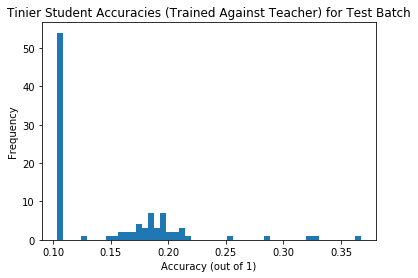

In [35]:
plt.hist(list_tinierstudentaccuracies_j_test, bins = 50)
plt.xlabel("Accuracy (out of 1)")
plt.ylabel("Frequency")
plt.title('Tinier Student Accuracies (Trained Against Teacher) for Test Batch')
plt.show()

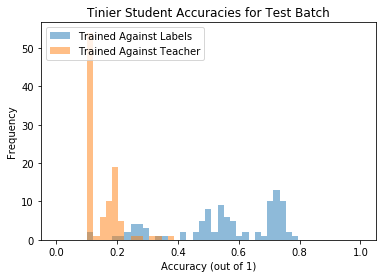

In [36]:
bins = np.linspace(0, 1, 50)

pyplot.hist(list_tinierstudentaccuracies_test, bins, alpha=0.5, label='Trained Against Labels')
pyplot.hist(list_tinierstudentaccuracies_j_test, bins, alpha=0.5, label='Trained Against Teacher')
pyplot.legend(loc='upper left')
plt.xlabel("Accuracy (out of 1)")
plt.ylabel("Frequency")
plt.title('Tinier Student Accuracies for Test Batch')
pyplot.show()

### Skinny-deep Student Network

In [37]:
# Initialise list of skinny-deep student networks
list_skinnydeepstudentnetworks = []

# Train 100 independent skinny-deep student networks against labels
for count in range(100):
    skinnydeep_student_i = make_skinnydeep_student()
    #train skinny-deep student network with labels
    skinnydeep_student_i_accuracies, skinnydeep_student_i_losses = train_student_against_labels(minibatchtrainloader, optim.SGD, 
                                                                                skinnydeep_student_i, epochs=2)
    list_skinnydeepstudentnetworks.append(skinnydeep_student_i)

EPOCH: 0



Training loss: 1.8701983852935498
EPOCH: 1



Training loss: 0.7958015027457971
EPOCH: 0



Training loss: 1.8097812225823717
EPOCH: 1



Training loss: 0.9054906603052164
EPOCH: 0



Training loss: 2.2901813539106453
EPOCH: 1



Training loss: 1.7060665343361876
EPOCH: 0



Training loss: 2.013255825174897
EPOCH: 1



Training loss: 1.1278592820869071
EPOCH: 0



Training loss: 1.9519563962909967
EPOCH: 1



Training loss: 0.8651830148277506
EPOCH: 0



Training loss: 2.055049040805556
EPOCH: 1



Training loss: 1.397190950763251
EPOCH: 0



Training loss: 2.301634053685772
EPOCH: 1



Training loss: 2.063964322177586
EPOCH: 0



Training loss: 2.2901872093997784
EPOCH: 1



Training loss: 1.8908695682787946
EPOCH: 0



Training loss: 1.928657341105089
EPOCH: 1



Training loss: 1.0667767235909953
EPOCH: 0



Training loss: 2.2489834708699794
EPOCH: 1



Training loss: 1.4889349064974389
EPOCH: 0



Training loss: 2.1882186986998455
EPOCH: 1



Training loss: 1.3377764642492795
EPOCH: 0



Training loss: 2.2722544582413713
EPOCH: 1



Training loss: 1.622193916011721
EPOCH: 0



Training loss: 2.302954531935995
EPOCH: 1



Training loss: 2.300330954828242
EPOCH: 0



Training loss: 2.0282580345424255
EPOCH: 1



Training loss: 1.2359899523924154
EPOCH: 0



Training loss: 2.2729533492629206
EPOCH: 1



Training loss: 1.6891864403478627
EPOCH: 0



Training loss: 2.0976033367073614
EPOCH: 1



Training loss: 1.296053732572588
EPOCH: 0



Training loss: 2.284626241940171
EPOCH: 1



Training loss: 1.7040317991394986
EPOCH: 0



Training loss: 1.999369109236101
EPOCH: 1



Training loss: 1.361510312697018
EPOCH: 0



Training loss: 2.3031675574113564
EPOCH: 1



Training loss: 1.6925792473592738
EPOCH: 0



Training loss: 1.9633701417618976
EPOCH: 1



Training loss: 0.7936152629633703
EPOCH: 0



Training loss: 2.144924678019623
EPOCH: 1



Training loss: 1.1679533523028847
EPOCH: 0



Training loss: 2.1853428082679636
EPOCH: 1



Training loss: 1.0925393791150437
EPOCH: 0



Training loss: 2.198944114037414
EPOCH: 1



Training loss: 1.562731306880776
EPOCH: 0



Training loss: 2.1569066402246193
EPOCH: 1



Training loss: 1.4512869430376267
EPOCH: 0



Training loss: 2.038674272072595
EPOCH: 1



Training loss: 1.1707413429771658
EPOCH: 0



Training loss: 2.206367597396948
EPOCH: 1



Training loss: 1.2594927797820776
EPOCH: 0



Training loss: 2.094606185645691
EPOCH: 1



Training loss: 1.0845860992667518
EPOCH: 0



Training loss: 2.065584930910993
EPOCH: 1



Training loss: 1.029106674068518
EPOCH: 0



Training loss: 2.1978159277423868
EPOCH: 1



Training loss: 1.7222833526668264
EPOCH: 0



Training loss: 2.2683362541422407
EPOCH: 1



Training loss: 1.4635130751615903
EPOCH: 0



Training loss: 2.1557571293194413
EPOCH: 1



Training loss: 1.1737536702201818
EPOCH: 0



Training loss: 1.8394065553953907
EPOCH: 1



Training loss: 0.9537882729252772
EPOCH: 0



Training loss: 1.8187564123413964
EPOCH: 1



Training loss: 1.0165336695688365
EPOCH: 0



Training loss: 2.239059481412363
EPOCH: 1



Training loss: 1.6846107355058828
EPOCH: 0



Training loss: 2.0773032333042574
EPOCH: 1



Training loss: 1.263154005445143
EPOCH: 0



Training loss: 2.144273895571735
EPOCH: 1



Training loss: 1.4007351029910513
EPOCH: 0



Training loss: 2.1473733126990067
EPOCH: 1



Training loss: 1.0906457216627816
EPOCH: 0



Training loss: 2.275878005444622
EPOCH: 1



Training loss: 1.4298617809947365
EPOCH: 0



Training loss: 2.3058639642780525
EPOCH: 1



Training loss: 2.301322851353871
EPOCH: 0



Training loss: 2.221059808471818
EPOCH: 1



Training loss: 1.6272957619827693
EPOCH: 0



Training loss: 2.2424478890545076
EPOCH: 1



Training loss: 1.521735956801026
EPOCH: 0



Training loss: 2.0136897521995025
EPOCH: 1



Training loss: 1.1791935379126433
EPOCH: 0



Training loss: 2.0024934907966077
EPOCH: 1



Training loss: 1.2283168301653506
EPOCH: 0



Training loss: 2.3042843847640797
EPOCH: 1



Training loss: 2.194118630784407
EPOCH: 0



Training loss: 2.303160885757983
EPOCH: 1



Training loss: 2.2251320436819277
EPOCH: 0



Training loss: 2.0324172791895836
EPOCH: 1



Training loss: 1.242239030566551
EPOCH: 0



Training loss: 2.1993909823869084
EPOCH: 1



Training loss: 1.573236133752347
EPOCH: 0



Training loss: 2.2921073617203147
EPOCH: 1



Training loss: 1.7208903228550323
EPOCH: 0



Training loss: 2.2918655508871018
EPOCH: 1



Training loss: 1.8219736600989727
EPOCH: 0



Training loss: 2.103036365783545
EPOCH: 1



Training loss: 1.6222475068147248
EPOCH: 0



Training loss: 2.0767729701772173
EPOCH: 1



Training loss: 1.2747406393988554
EPOCH: 0



Training loss: 2.2963800160869607
EPOCH: 1



Training loss: 1.5322430024523217
EPOCH: 0



Training loss: 2.2112437123174606
EPOCH: 1



Training loss: 1.6232298648179466
EPOCH: 0



Training loss: 2.3047587129352953
EPOCH: 1



Training loss: 2.146690967494745
EPOCH: 0



Training loss: 2.086438729437684
EPOCH: 1



Training loss: 1.041923110927346
EPOCH: 0



Training loss: 2.1421024691321446
EPOCH: 1



Training loss: 1.372157416364023
EPOCH: 0



Training loss: 2.2645809895702516
EPOCH: 1



Training loss: 1.6945656062062107
EPOCH: 0



Training loss: 2.109566470071959
EPOCH: 1



Training loss: 1.3613792910758875
EPOCH: 0



Training loss: 2.3010742183941515
EPOCH: 1



Training loss: 1.687187691677862
EPOCH: 0



Training loss: 2.176635141438767
EPOCH: 1



Training loss: 1.269083504038833
EPOCH: 0



Training loss: 2.2625786773939884
EPOCH: 1



Training loss: 1.6859605354286715
EPOCH: 0



Training loss: 2.107570206559797
EPOCH: 1



Training loss: 1.356807505779429
EPOCH: 0



Training loss: 2.0895703723435717
EPOCH: 1



Training loss: 1.433072940500052
EPOCH: 0



Training loss: 1.962007773964644
EPOCH: 1



Training loss: 0.9903104628708317
EPOCH: 0



Training loss: 2.3055108218813247
EPOCH: 1



Training loss: 1.8697365235163967
EPOCH: 0



Training loss: 2.1876462658585263
EPOCH: 1



Training loss: 1.704316512989337
EPOCH: 0



Training loss: 2.2952497427397445
EPOCH: 1



Training loss: 1.5939901203616087
EPOCH: 0



Training loss: 2.30426186310457
EPOCH: 1



Training loss: 2.05012355214243
EPOCH: 0



Training loss: 2.2281573684230795
EPOCH: 1



Training loss: 1.6888555383631416
EPOCH: 0



Training loss: 2.3024903807812915
EPOCH: 1



Training loss: 1.8673632043256942
EPOCH: 0



Training loss: 2.243582423943192
EPOCH: 1



Training loss: 1.3145025092274396
EPOCH: 0



Training loss: 2.241176616027157
EPOCH: 1



Training loss: 1.6148137554431012
EPOCH: 0



Training loss: 2.209570134499434
EPOCH: 1



Training loss: 1.3444564999865571
EPOCH: 0



Training loss: 2.075305916480164
EPOCH: 1



Training loss: 1.550657311799938
EPOCH: 0



Training loss: 2.303571471019086
EPOCH: 1



Training loss: 2.028830704277258
EPOCH: 0



Training loss: 2.262893780970624
EPOCH: 1



Training loss: 1.5665168528363649
EPOCH: 0



Training loss: 2.1114326392663822
EPOCH: 1



Training loss: 1.3894462392274252
EPOCH: 0



Training loss: 2.270838384435121
EPOCH: 1



Training loss: 1.7171297347876056
EPOCH: 0



Training loss: 2.117415897119274
EPOCH: 1



Training loss: 1.3415242933642382
EPOCH: 0



Training loss: 1.9899509711814587
EPOCH: 1



Training loss: 0.9040116110780855
EPOCH: 0



Training loss: 2.2917710430840694
EPOCH: 1



Training loss: 1.872556217062448
EPOCH: 0



Training loss: 2.0623824686638073
EPOCH: 1



Training loss: 1.3168706493591196
EPOCH: 0



Training loss: 2.252951374567394
EPOCH: 1



Training loss: 1.8045888335974232
EPOCH: 0



Training loss: 2.252214729150475
EPOCH: 1



Training loss: 1.7534835494911747
EPOCH: 0



Training loss: 2.1762658993064212
EPOCH: 1



Training loss: 1.5003114668672273
EPOCH: 0



Training loss: 2.302575820798813
EPOCH: 1



Training loss: 2.1421273199479973
EPOCH: 0



Training loss: 2.078078072970864
EPOCH: 1



Training loss: 1.1860904114078612
EPOCH: 0



Training loss: 2.0720533366396485
EPOCH: 1



Training loss: 1.1186443438916318
EPOCH: 0



Training loss: 2.2629932179125642
EPOCH: 1



Training loss: 1.7073858709477667
EPOCH: 0



Training loss: 2.1923349514953108
EPOCH: 1



Training loss: 1.3963217279677198
EPOCH: 0



Training loss: 2.2876995837510523
EPOCH: 1



Training loss: 1.7077116504915233
EPOCH: 0



Training loss: 2.1568660352275826
EPOCH: 1



Training loss: 1.7178168535740899
EPOCH: 0



Training loss: 2.302920965243504
EPOCH: 1



Training loss: 2.0527440669185824
EPOCH: 0



Training loss: 2.1290417120400775
EPOCH: 1



Training loss: 1.3703160390797964
EPOCH: 0



Training loss: 2.3016453015524694
EPOCH: 1



Training loss: 1.9520278553972874
EPOCH: 0



Training loss: 2.100484751307888
EPOCH: 1



Training loss: 1.3735513942582267
EPOCH: 0



Training loss: 2.3019848154551945
EPOCH: 1



Training loss: 1.969583640856021
EPOCH: 0



Training loss: 2.2138797611570054
EPOCH: 1



Training loss: 1.643995320237776
EPOCH: 0



Training loss: 2.0351878995580206
EPOCH: 1



Training loss: 1.3169063029767099
EPOCH: 0



Training loss: 2.10406376875794
EPOCH: 1



Training loss: 1.790261775700014


In [38]:
# Initialise list of accuracies of the skinny-deep student networks
list_skinnydeepstudentaccuracies_test = []

#Obtain accuracies for the 100 skinny-deep student networks run on testing batch.
for i in range(len(list_skinnydeepstudentnetworks)):
    skinnydeep_student_accuracies_test = test_network_against_labels(testloader, list_skinnydeepstudentnetworks[i], epochs=1)
    list_skinnydeepstudentaccuracies_test.append(skinnydeep_student_accuracies_test[0])
    
print(list_skinnydeepstudentaccuracies_test)

EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



[0.817, 0.7727, 0.557, 0.7432, 0.8174, 0.6368, 0.2491, 0.3143, 0.7609, 0.617, 0.7482, 0.5593, 0.1135, 0.5977, 0.435, 0.6873, 0.3856, 0.3887, 0.5959, 0.7532, 0.8011, 0.6527, 0.5033, 0.3933, 0.7138, 0.697, 0.687, 0.7186, 0.3462, 0.6053, 0.7343, 0.6793, 0.7422, 0.44, 0.5272, 0.5994, 0.735, 0.7403, 0.1135, 0.4824, 0.6132, 0.7227, 0.6725, 0.2113, 0.3345, 0.6918, 0.5568, 0.456, 0.3874, 0.4173, 0.324, 0.6509, 0.5359, 0.2559, 0.6438, 0.7358, 0.6508, 0.6497, 0.4168, 0.5926, 0.4957, 0.597, 0.5652, 0.7803, 0.4338, 0.4691, 0.529, 0.2242, 0.6075, 0.4675, 0.7293, 0.6605, 0.7772, 0.2354, 0.3812, 0.4108, 0.6556, 0.5124, 0.6808, 0.7561, 0.2862, 0.6948, 0.3696, 0.4476, 0.5703, 0.2905, 0.7218, 0.7085, 0.4916, 0.5549, 0.4296, 0.3543, 0.2805, 0.7157, 0.3009, 0.6225, 0.2881, 0.6026, 0.605, 0.4359]


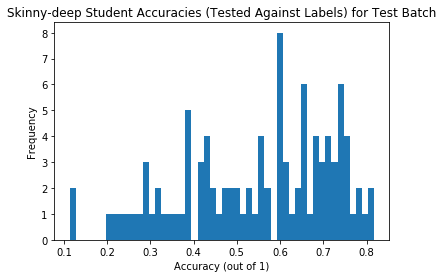

In [39]:
plt.hist(list_skinnydeepstudentaccuracies_test, bins = 50)
plt.xlabel("Accuracy (out of 1)")
plt.ylabel("Frequency")
plt.title('Skinny-deep Student Accuracies (Tested Against Labels) for Test Batch')
plt.show()

In [40]:
# Build a feed-forward network for the teacher.
teacher = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

#train teacher network with labels
teacher_accuracies_2, teacher_losses_2 = train_teacher(trainloader, optim.SGD, teacher, epochs=2)

# Initialise list of skinny-deep student networks
list_skinnydeepstudentnetworks_1 = []

# Train 100 independent skinny-deep student networks against output of teacher network
for counts in range(100):
    skinnydeep_student_j = make_skinnydeep_student()
    #train skinny-deep student network with output of teacher network
    skinnydeep_student_j_accuracies_wrt_labels, skinnydeep_student_j_accuracies_wrt_teacher, tinier_student_j_losses_wrt_teacher, tinier_student_j_snr = train_student_against_teacher(trainloader, optim.SGD, teacher, skinnydeep_student_j, epochs=2)
    
    list_skinnydeepstudentnetworks_1.append(skinnydeep_student_j)

EPOCH: 0



Training loss: 0.6076921832396277
EPOCH: 1



Training loss: 0.28080215672058845
EPOCH: 0



Training loss: 11.917292894330869
EPOCH: 1



Training loss: 6.50837648169064
EPOCH: 0



Training loss: 10.221535981591067
EPOCH: 1



Training loss: 4.774183901388254
EPOCH: 0



Training loss: 11.423558120280186
EPOCH: 1



Training loss: 3.962360104009795
EPOCH: 0



Training loss: 10.36031611235157
EPOCH: 1



Training loss: 4.779531370602183
EPOCH: 0



Training loss: 11.410049456268993
EPOCH: 1



Training loss: 6.3199530804335184
EPOCH: 0



Training loss: 13.31395736076176
EPOCH: 1



Training loss: 7.020652573500106
EPOCH: 0



Training loss: 11.043190341005955
EPOCH: 1



Training loss: 4.560705912138608
EPOCH: 0



Training loss: 10.525939321212931
EPOCH: 1



Training loss: 5.527292185246563
EPOCH: 0



Training loss: 10.111702207054918
EPOCH: 1



Training loss: 4.283936175202002
EPOCH: 0



Training loss: 10.542781046458654
EPOCH: 1



Training loss: 4.91051853592716
EPOCH: 0



Training loss: 10.779253300319095
EPOCH: 1



Training loss: 4.911071040737095
EPOCH: 0



Training loss: 9.50287454290939
EPOCH: 1



Training loss: 4.015599491245457
EPOCH: 0



Training loss: 11.319256224357751
EPOCH: 1



Training loss: 4.782087879648595
EPOCH: 0



Training loss: 9.795408479694618
EPOCH: 1



Training loss: 4.686693153910037
EPOCH: 0



Training loss: 11.796963472610344
EPOCH: 1



Training loss: 4.577149254426773
EPOCH: 0



Training loss: 7.296047535532319
EPOCH: 1



Training loss: 3.535033964780348
EPOCH: 0



Training loss: 11.54268062394311
EPOCH: 1



Training loss: 5.851913862645245
EPOCH: 0



Training loss: 8.444168350081455
EPOCH: 1



Training loss: 3.1762808652829007
EPOCH: 0



Training loss: 14.820598968310652
EPOCH: 1



Training loss: 14.665885880557713
EPOCH: 0



Training loss: 11.061525150656955
EPOCH: 1



Training loss: 5.185020370269889
EPOCH: 0



Training loss: 11.1238839504307
EPOCH: 1



Training loss: 4.579171734578066
EPOCH: 0



Training loss: 10.900708027231667
EPOCH: 1



Training loss: 4.9897260157538375
EPOCH: 0



Training loss: 11.949701915163475
EPOCH: 1



Training loss: 4.42926793718643
EPOCH: 0



Training loss: 8.272863143288504
EPOCH: 1



Training loss: 3.4052934323800907
EPOCH: 0



Training loss: 10.612267937995732
EPOCH: 1



Training loss: 4.27740486217206
EPOCH: 0



Training loss: 11.809177019957032
EPOCH: 1



Training loss: 6.932638874694483
EPOCH: 0



Training loss: 9.663305475259387
EPOCH: 1



Training loss: 4.248524523493069
EPOCH: 0



Training loss: 10.387676741014412
EPOCH: 1



Training loss: 3.7929507487618337
EPOCH: 0



Training loss: 14.201731669623205
EPOCH: 1



Training loss: 14.667783336598736
EPOCH: 0



Training loss: 9.916018081880582
EPOCH: 1



Training loss: 3.6148309046779867
EPOCH: 0



Training loss: 11.23292741999189
EPOCH: 1



Training loss: 6.692190377188644
EPOCH: 0



Training loss: 13.525520676488815
EPOCH: 1



Training loss: 14.667120846095624
EPOCH: 0



Training loss: 9.485029472216869
EPOCH: 1



Training loss: 3.8733258585431685
EPOCH: 0



Training loss: 8.813060401853468
EPOCH: 1



Training loss: 3.3006992746772035
EPOCH: 0



Training loss: 9.645825903807113
EPOCH: 1



Training loss: 3.343455888569228
EPOCH: 0



Training loss: 9.488114399442287
EPOCH: 1



Training loss: 3.9391328388694
EPOCH: 0



Training loss: 11.935874801708945
EPOCH: 1



Training loss: 6.84876853265742
EPOCH: 0



Training loss: 10.313035336130463
EPOCH: 1



Training loss: 5.001323311567815
EPOCH: 0



Training loss: 12.740821080929688
EPOCH: 1



Training loss: 6.595082444676967
EPOCH: 0



Training loss: 10.931218381121214
EPOCH: 1



Training loss: 7.367982745424771
EPOCH: 0



Training loss: 9.798036597176656
EPOCH: 1



Training loss: 3.9261900613557046
EPOCH: 0



Training loss: 8.929033092852595
EPOCH: 1



Training loss: 3.9142566898992577
EPOCH: 0



Training loss: 11.245412836705189
EPOCH: 1



Training loss: 5.6024600178448125
EPOCH: 0



Training loss: 11.437525331338586
EPOCH: 1



Training loss: 7.802360063422718
EPOCH: 0



Training loss: 12.471399955912185
EPOCH: 1



Training loss: 13.115297590999969
EPOCH: 0



Training loss: 11.258077396258617
EPOCH: 1



Training loss: 7.30934873877812
EPOCH: 0



Training loss: 10.983268592911744
EPOCH: 1



Training loss: 5.3239348809093805
EPOCH: 0



Training loss: 11.189348227433813
EPOCH: 1



Training loss: 9.612701331628665
EPOCH: 0



Training loss: 10.134811130413876
EPOCH: 1



Training loss: 4.756540531542764
EPOCH: 0



Training loss: 8.902856761966941
EPOCH: 1



Training loss: 3.4851595064216077
EPOCH: 0



Training loss: 10.476062280028614
EPOCH: 1



Training loss: 4.444058544091833
EPOCH: 0



Training loss: 10.777931092390373
EPOCH: 1



Training loss: 3.6514444057621174
EPOCH: 0



Training loss: 10.295690792710033
EPOCH: 1



Training loss: 4.540070619410289
EPOCH: 0



Training loss: 8.825348352318379
EPOCH: 1



Training loss: 3.5180862821749788
EPOCH: 0



Training loss: 11.274146738337047
EPOCH: 1



Training loss: 5.466500287371149
EPOCH: 0



Training loss: 9.178745654346084
EPOCH: 1



Training loss: 4.485944322939875
EPOCH: 0



Training loss: 9.818695214765667
EPOCH: 1



Training loss: 3.8066112237698486
EPOCH: 0



Training loss: 10.471606712097298
EPOCH: 1



Training loss: 4.404380912211404
EPOCH: 0



Training loss: 11.062193727188273
EPOCH: 1



Training loss: 4.604927671489431
EPOCH: 0



Training loss: 8.680980953834712
EPOCH: 1



Training loss: 3.687207806847497
EPOCH: 0



Training loss: 9.875137081024235
EPOCH: 1



Training loss: 5.3422390756322375
EPOCH: 0



Training loss: 11.418119957197957
EPOCH: 1



Training loss: 7.29229018505194
EPOCH: 0



Training loss: 8.57454834030127
EPOCH: 1



Training loss: 3.819658107340717
EPOCH: 0



Training loss: 11.418362852352768
EPOCH: 1



Training loss: 7.224090084592417
EPOCH: 0



Training loss: 10.559851566611577
EPOCH: 1



Training loss: 5.339872232123987
EPOCH: 0



Training loss: 10.171581625684238
EPOCH: 1



Training loss: 3.9981550921255082
EPOCH: 0



Training loss: 10.792143333695336
EPOCH: 1



Training loss: 5.3458078337122386
EPOCH: 0



Training loss: 9.44008167034019
EPOCH: 1



Training loss: 3.6879179700097042
EPOCH: 0



Training loss: 10.422251896817547
EPOCH: 1



Training loss: 3.769183736874351
EPOCH: 0



Training loss: 8.182900667698908
EPOCH: 1



Training loss: 3.689341931454917
EPOCH: 0



Training loss: 9.854323803997243
EPOCH: 1



Training loss: 4.712616646213572
EPOCH: 0



Training loss: 11.723967420521067
EPOCH: 1



Training loss: 4.804718252692395
EPOCH: 0



Training loss: 10.474889390250004
EPOCH: 1



Training loss: 4.110656628222354
EPOCH: 0



Training loss: 9.015380734573803
EPOCH: 1



Training loss: 3.388658915247236
EPOCH: 0



Training loss: 8.526855025718461
EPOCH: 1



Training loss: 3.152068972968852
EPOCH: 0



Training loss: 9.022893619181504
EPOCH: 1



Training loss: 3.307031646720382
EPOCH: 0



Training loss: 13.182891173149223
EPOCH: 1



Training loss: 8.083078042276378
EPOCH: 0



Training loss: 9.386978722584526
EPOCH: 1



Training loss: 3.1303892200435404
EPOCH: 0



Training loss: 12.570977806790806
EPOCH: 1



Training loss: 14.67866013553351
EPOCH: 0



Training loss: 9.819825841928088
EPOCH: 1



Training loss: 4.075190262245471
EPOCH: 0



Training loss: 10.284978316536844
EPOCH: 1



Training loss: 6.34313906637082
EPOCH: 0



Training loss: 8.526689236098006
EPOCH: 1



Training loss: 4.289862283511456
EPOCH: 0



Training loss: 10.204546338713754
EPOCH: 1



Training loss: 4.913626044797999
EPOCH: 0



Training loss: 9.680216505583415
EPOCH: 1



Training loss: 4.323125712398781
EPOCH: 0



Training loss: 9.452336078767837
EPOCH: 1



Training loss: 4.099092536389446
EPOCH: 0



Training loss: 9.541871114072007
EPOCH: 1



Training loss: 4.884822660417699
EPOCH: 0



Training loss: 11.462073021097732
EPOCH: 1



Training loss: 6.344337112105477
EPOCH: 0



Training loss: 10.530838256705799
EPOCH: 1



Training loss: 4.711964889121717
EPOCH: 0



Training loss: 11.424520850435757
EPOCH: 1



Training loss: 5.435258535179757
EPOCH: 0



Training loss: 9.597740357618596
EPOCH: 1



Training loss: 4.098213253244917
EPOCH: 0



Training loss: 12.510383225707358
EPOCH: 1



Training loss: 8.658204869166621
EPOCH: 0



Training loss: 9.12579487432549
EPOCH: 1



Training loss: 4.3197186831980625
EPOCH: 0



Training loss: 9.883682517863031
EPOCH: 1



Training loss: 5.245485886327748
EPOCH: 0



Training loss: 9.144116914602739
EPOCH: 1



Training loss: 3.717888999341139
EPOCH: 0



Training loss: 11.829005371024614
EPOCH: 1



Training loss: 6.706343095439838
EPOCH: 0



Training loss: 8.664490456520113
EPOCH: 1



Training loss: 3.1410466454176507
EPOCH: 0



Training loss: 9.062811863956167
EPOCH: 1



Training loss: 3.888465600989775
EPOCH: 0



Training loss: 11.921195009878195
EPOCH: 1



Training loss: 5.603981381540359
EPOCH: 0



Training loss: 10.046705992745439
EPOCH: 1



Training loss: 4.999272260584557
EPOCH: 0



Training loss: 11.574345187083491
EPOCH: 1



Training loss: 6.352289495437638


In [41]:
# Initialise list of accuracies of the skinny-deep student networks
list_skinnydeepstudentaccuracies_j_test = []

#Obtain accuracies for the 100 skinny-deep student networks run on testing batch.
for i in range(len(list_skinnydeepstudentnetworks_1)):
    skinnydeep_student_accuracies_j_test = test_network_against_labels(testloader, list_skinnydeepstudentnetworks_1[i], epochs=1)
    list_skinnydeepstudentaccuracies_j_test.append(skinnydeep_student_accuracies_j_test[0])
    
print(list_tinierstudentaccuracies_j_test)

EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



EPOCH: 0



[0.1032, 0.1032, 0.1032, 0.1758, 0.1797, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1694, 0.1032, 0.1032, 0.1957, 0.1032, 0.1032, 0.1032, 0.1913, 0.1626, 0.1632, 0.1032, 0.3676, 0.1962, 0.1903, 0.1995, 0.2135, 0.1032, 0.1032, 0.1032, 0.1032, 0.1577, 0.1032, 0.1032, 0.1573, 0.1032, 0.1032, 0.1032, 0.1976, 0.1032, 0.1513, 0.3294, 0.1032, 0.2832, 0.2106, 0.1879, 0.2524, 0.1032, 0.1757, 0.3242, 0.1958, 0.1853, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1966, 0.128, 0.1032, 0.1771, 0.1807, 0.1783, 0.1833, 0.1032, 0.1992, 0.1847, 0.1692, 0.1032, 0.1966, 0.1032, 0.1032, 0.213, 0.1032, 0.1032, 0.1032, 0.1744, 0.185, 0.1032, 0.1875, 0.187, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1032, 0.1471, 0.1948, 0.2144, 0.1032, 0.2037, 0.1032, 0.2059, 0.1032, 0.1845]


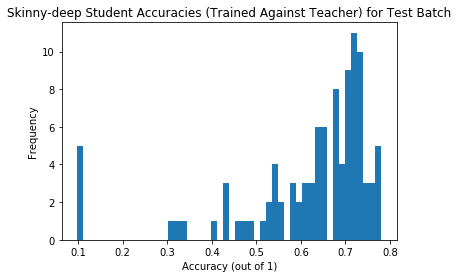

In [42]:
plt.hist(list_skinnydeepstudentaccuracies_j_test, bins = 50)
plt.xlabel("Accuracy (out of 1)")
plt.ylabel("Frequency")
plt.title('Skinny-deep Student Accuracies (Trained Against Teacher) for Test Batch')
plt.show()

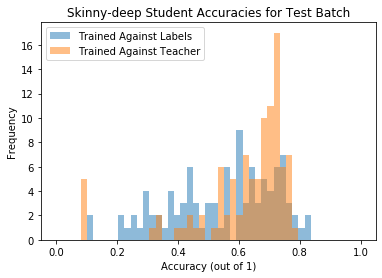

In [43]:
bins = np.linspace(0, 1, 50)

pyplot.hist(list_skinnydeepstudentaccuracies_test, bins, alpha=0.5, label='Trained Against Labels')
pyplot.hist(list_skinnydeepstudentaccuracies_j_test, bins, alpha=0.5, label='Trained Against Teacher')
pyplot.legend(loc='upper left')
plt.xlabel("Accuracy (out of 1)")
plt.ylabel("Frequency")
plt.title('Skinny-deep Student Accuracies for Test Batch')
pyplot.show()